In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

from pyspark.mllib.stat import Statistics
%matplotlib inline

import findspark
findspark.init()

# Import and start a Spark session.
from pyspark.sql import *
import pyspark.sql.functions as F
from pyspark.sql.types import DoubleType, StringType

spark = SparkSession.builder.getOrCreate()
plt.rcParams['figure.figsize'] = [12, 8]

import warnings
warnings.filterwarnings('ignore')

from igraph import *
import bokeh
import json

import holoviews as hv
import networkx as nx
from holoviews.operation.datashader import datashade, bundle_graph


from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from sklearn.model_selection import TimeSeriesSplit
from scipy.spatial.distance import euclidean

from fastdtw import fastdtw
import statsmodels.tsa
from scipy.spatial.distance import pdist, squareform

hv.extension('bokeh');

%opts Graph [width=400 height=400]

plt.rcParams['figure.figsize'] = [12, 8]

In [2]:
# Set default figure styles using Seaborn.
sns.set()
sns.set_style(rc={'patch.edgecolor': 'black'})
matplotlib.rcParams['figure.figsize'] = [12, 8]
sns.reset_orig()

# Analyze of hashtags as a whole

The first part of our work is the analysis of how hashtags behave. Here, we want to understand the general behavior. A more precise analyse on specific hashtags will come latter.

## Creating our datasets

As the twitter dataset is huge, we can't work directly on it, we must find a way to extract insights from it that are usefull from our analysis. We are particularly interested in two metrics: 
- the count of tweets having a given hashtag
- the exposure (which we are calling "print") of tweets having a given hashtag. The exposure of a tweet is defined as an approximation of the audience reached by it, which is approximately the number of followers of the author. Then, we can approximate the exposure of several tweets by the sums of the followers of every authors. This is an over approximation as some users could have common followers, but it should be good enough.

Then, for each hashtag $h$ we are extracting the following insights:
- the total count of tweets having the hashtag $h$
- for each day the total count of tweets having the hashtag $h$ and tweeted on this day
- the exposure of tweets having the hashtag $h$
- for each day the exposure of tweets having the hashtag $h$ and tweeted on this day

More concretely, we ran the script `hashtag_insights.py` for each month on the cluster. Then, we merged the insights of different months as explained below.

### Merging of monthly insights into an insights dataframe.

We start by loading our monthly insights extracted from the cluster. We load every month of 2017 at the exception of:
- January, as we never managed to open it on the cluster
- June, as it contain nearly no data on the cluster
- December as it was absent of the cluster

In [26]:
def load_insights(months):
    return {month: spark.read.parquet('data/hashtags_insights_{}.parquet'.format(month)) for month in months} 

hashtags = load_insights(['02', '03', '04', '05', '07', '08', '09', '10', '11'])

For reasons we didn't understood, our hashtags insights for the month of augusts contained some duplicates rows. Hence, we remove them before continuing our analysis.

In [ ]:
hashtags['08'] = hashtags['08'].dropDuplicates()

For each monthly hashtags, some days could be absent (which is the case for the month of November where the 19th, 20th, 21st, 22nd, 23rd, 24th and 25th are missing). We remove the corresponding rows. For rows that still exists we prefix them. As rows `count` and `print` can be recomputed easily, to avoid any conflicts when joining the monthly insights we remove them.

In [ ]:
def rename_columns(insights, prefix):
    printCols = [c for c in insights.columns if "print_" in c]
    nameCols = [c for c in insights.columns if "count_" in c]
    print(insights, prefix)
    for x in printCols + nameCols:
        if insights.where(F.col(x) != 0).count() == 0:
            insights = insights.drop(x)
        else:
            insights = insights.withColumnRenamed(x, prefix + "_" + x)
    return insights.drop("count").drop("print")

In [ ]:
insights = [rename_columns(hashtags[key], key) for key in hashtags]

We now join every monthly hashtags by using an outer join.

In [ ]:
from functools import reduce

def joinAll(dfs):
    return reduce(lambda prev, cur: cur.join(prev, on='tag', how='outer'), dfs)

In [ ]:
unifiedInsights = joinAll(insights)

We then replace Nan entries by 0 and we recompute rows `count` and `print`.

In [ ]:
unifiedInsights = unifiedInsights.fillna(0).cache()
count_columns = [c for c in unifiedInsights.columns if "count" in c]
unifiedInsights = unifiedInsights.withColumn("count", sum(F.col(c) for c in count_columns))
print_columns = [c for c in unifiedInsights.columns if "print" in c]
unifiedInsights = unifiedInsights.withColumn("print", sum(F.col(c) for c in print_columns))

Finally we export this dataset to a parquet file.

In [ ]:
unifiedInsights.write.mode("overwrite").parquet("data/hashtags-insights.parquet")

### Building a "compressed insights" from our insights.

For convenience, we also decided to build a new dataset from the previous one. The main difference is in how we store the count per day and the print per day. In the previous dataset we had one column per day for the count and the exposure. In the one we will be building, we will have a row which will be an array of counts, and a row which will be an array of exposure (the ith entry maps to day i). These arrays will be relative to the row count and print, that is normalized between 0 and 1. This allows us to compare the behavior of two hashtags more accurately.

In [4]:
insights = spark.read.parquet("data/hashtags-insights.parquet")

We first build a time-sorted list of names of columns corresponding to a hashtag count. We also build the equivalent for the exposure.

In [7]:
def key(c):
    """ Parse a column name of the form month_(print|count)_day in a tuple (month, day)"""
    month, _, day = c.split("_")
    return int(month), int(day)


count_columns_wkey = [(c, key(c)) for c in insights.columns if "count_" in c]
count_columns_wkey.sort(key=lambda x: x[1])
count_columns = [a for a, _ in count_columns_wkey]
count_days = [b for _, b in count_columns_wkey]

print_columns_wkey = [(c, key(c)) for c in insights.columns if "print_" in c]
print_columns_wkey.sort(key=lambda x: x[1])
print_columns = [a for a, _ in print_columns_wkey]
print_days = [b for _, b in print_columns_wkey]

We create a new column `count_daily` which will be the array of normalized daily counts and drop the columns that have become useless.

In [ ]:
insights_compressed = \
    insights \
    .withColumn("count_daily", F.array(*[F.col(c) / F.col('count') for c in count_columns])) \
    .select(*[c for c in insights_compressed.columns if not c in count_columns])

We know do the same to add `print_daily`, which is the equivalent of `count_daily` but for the exposure.

In [ ]:
insights_compressed = \
    insights_compressed \
    .withColumn("print_daily", F.array(*[F.col(c) / F.col('print') for c in print_columns])) \
    .select(*[c for c in insights_compressed.columns if not c in print_columns])

Then we export the resulting dataset to a parquet file.

In [ ]:
insights_compressed.write.parquet("data/insights-compressed.parquet")

### Cleaning up the followers dataset

We also extracted from the clusters a dataset of the users who tweeted in july. This dataset is of the form (user id, number of followers).

Unfortunately this dataset as multiple duplicates. We will remove them and also compute the number of tweets in which a user took part. 

In [4]:
followers = spark.read.parquet("data/followers_count_07.parquet")

In [5]:
followers_unique = \
    followers \
    .groupby('userID') \
    .agg(F.count(F.lit(1)).alias('n_tweets'), F.max(F.col('followersCount')).alias('followersCount')) \
    .cache()

We have more than 25million distinct users:

In [6]:
followers_unique.count()

27602081

Finally we can export the dataset.

In [ ]:
followers_unique.write.parquet('followers.parquet')

## Analysis of hashtags insight

We start by loading our two datasets:

In [5]:
insights = spark.read.parquet("data/hashtags-insights.parquet")

In [11]:
insights_compressed = spark.read.parquet("data/insights-compressed.parquet")

In [5]:
insights.cache()
insights_compressed.cache()

DataFrame[tag: string, count: bigint, print: bigint, count_daily: array<double>, print_daily: array<double>]

### General statistics

We have around 15 million different hashtags in the dataset.

In [5]:
insights.count()

15177260

The average exposure is of 134 thousand people, while on average an hashtag appears 21 time in our dataset. Do not forget that we extracted the hashtags from a 1% sample of twitter, hence the truth is that the true average of the number of occurences is more likely to be around 2100.

In [34]:
insights.agg({"count": "avg", "print": "avg"}).show()

+------------------+------------------+
|        avg(print)|        avg(count)|
+------------------+------------------+
|134616.39214831925|21.220559969322526|
+------------------+------------------+



However, the average count, and even the average print are completly biased by the outliers. The median of the count is 1!

In [44]:
insights.approxQuantile('count', [.25, .5, .75], .001)

[1.0, 1.0, 3.0]

In [38]:
insights.approxQuantile('print', [.25, .5, .75], .001)

[143.0, 710.0, 3968.0]

**Analyse of the distribution of the number of occurences**

In fact, only 38% of the hashtags are present more than once.

In [51]:
100 * float(insights.where(F.col('count') > 1).count()) / float(insights.count())

38.79508554244969

More surprisingly, .78% of hashtags are present at least 250 times. 

In [224]:
100 * float(insights.where(F.col('count') > 250).count()) / float(insights.count())

0.7877377075967599

Starting from now, we will pursue our analysis only on hashtags occuring more than 250 times: this a good compromise about "generality" and focusing on "viral" tweets.

In [6]:
THRESHOLD_COUNT = 250

The histogram of the number of occurrences shows clearly that the number of occurrences is sharply decreasing.
The noise at the start of the histogram might be due to the sampling: missing one tweet out of 50 is more impactfull than one tweet out of 250. 

In [424]:
bins, counts = insights.where(F.col('count') > 50) \
        .select(F.log10('count')).rdd \
        .flatMap(lambda x: x) \
        .histogram(150)

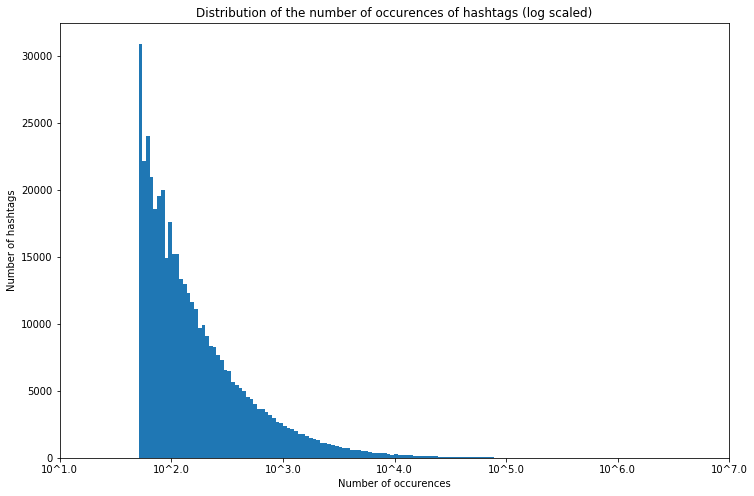

In [425]:
plt.hist(bins[:-1], bins=bins, weights=counts)
plt.title('Distribution of the number of occurences of hashtags (log scaled)' )
plt.ylabel('Number of hashtags')
plt.xlabel('Number of occurences')
locs, _ = plt.xticks()
labels = ["10^{}".format(l) for l in locs]
plt.xticks(locs, labels);

In fact, it is even following a power-law:

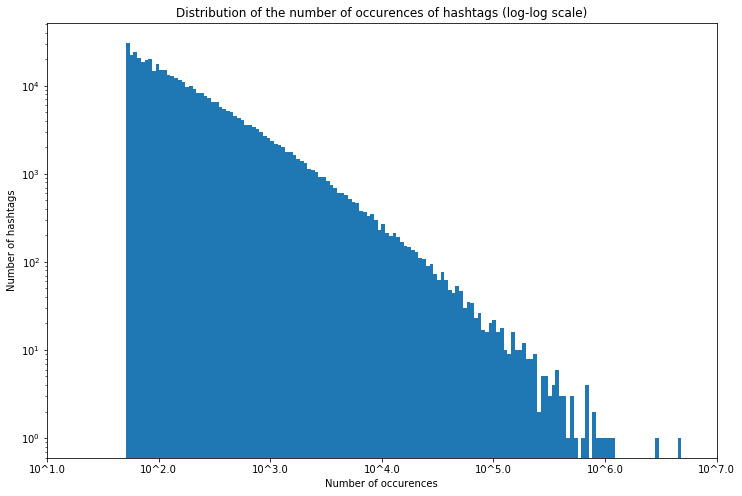

In [98]:
plt.hist(bins[:-1], bins=bins, weights=counts, log=True)
plt.title('Distribution of the number of occurences of hashtags (log-log scale)' )
plt.ylabel('Number of hashtags')
plt.xlabel('Number of occurences')
locs, _ = plt.xticks()
labels = ["10^{}".format(l) for l in locs]
plt.xticks(locs, labels);

We finally plot the log-log histogram for all the values, to use in the data story.

In [6]:
bins, counts = insights.select(F.log10('count')).rdd \
        .flatMap(lambda x: x) \
        .histogram(150)

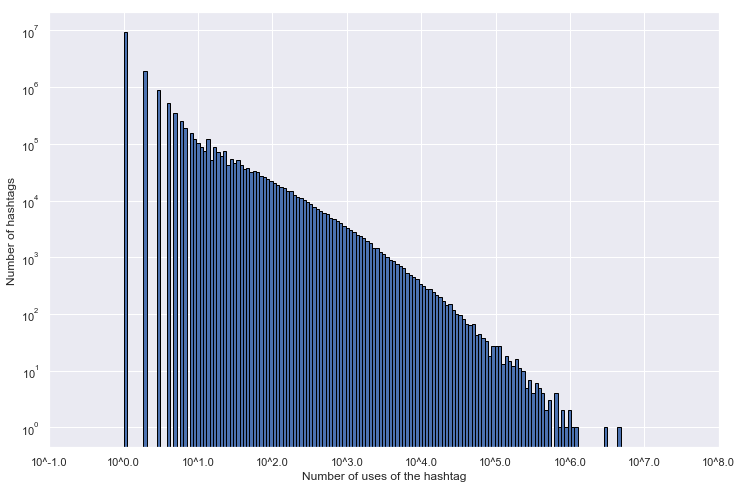

In [10]:
plt.hist(bins[:-1], bins=bins, weights=counts, log=True)
plt.ylabel('Number of hashtags')
plt.xlabel('Number of uses of the hashtag')
locs, _ = plt.xticks()
labels = ["10^{}".format(l) for l in locs]
plt.xticks(locs, labels);

We also check to which extent this distribution follows the Pareto principle.

In [27]:
# Total count of hashtags uses.
insights.select(F.sum('count')).collect()

[Row(sum(count)=322069956)]

In [50]:
# Top 1% of hashtags.
top_hashtags = insights.where(F.col('count') > 50).sort('count', ascending=False).limit(insights.count() // 100)

In [51]:
# Count of hashtag uses for the top 1% hashtags.
top_hashtags.select(F.sum('count')).collect()

[Row(sum(count)=247486969)]

In [54]:
top_hashtags_usage = 100*247486969/322069956
top_hashtags_usage

76.84261272727966

So we actually get something even more radical: the top 1% of hashtags accounts for more than 75% of hashtag use on Twitter.

**Analyse of the distribution of the exposure**

Once again we plot the log distribution of the exposure. We chose to use a threshold of 250000: only 2.9% of the tweets have a bigger exposure.

In [226]:
100 * float(insights.where(F.col('print') > 250000).count()) / float(insights.count())

2.869944904416212

In [55]:
bins, counts = insights.where(F.col('print') > 1) \
        .select(F.log10('print')).rdd \
        .flatMap(lambda x: x) \
        .histogram(150)

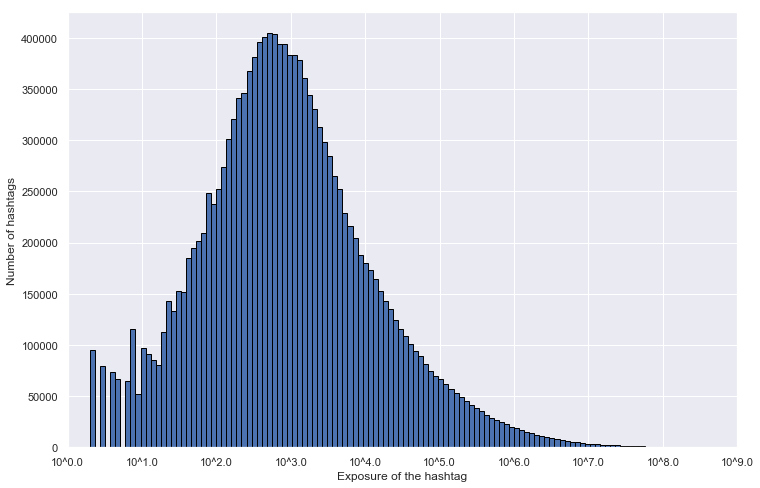

In [64]:
plt.hist(bins[:-1], bins=bins, weights=counts)
plt.ylabel('Number of hashtags')
plt.xlabel('Exposure of the hashtag')
axes = plt.gca()
axes.set_xlim([0, 9])
locs, _ = plt.xticks()
labels = ["10^{}".format(l) for l in locs]
plt.xticks(locs, labels);

In [76]:
# Total number of hashtags seen more than ten million times.
sum([counts[i] for (i, b) in enumerate(bins[:-1]) if b > 7])

24344

We were suprised by this bell shape curve. As the way we are building the exposure is strongly linked to the number of followers, we decided to extract the number of followers for all users having twitted in July 2017. As there are 110 millions of these users, the data obtained is quite reliable. Below you can find the histogram of the number of users.

In [8]:
followers = spark.read.parquet("followers.parquet")

In [10]:
bins, counts = followers \
        .select(F.log10('followersCount')).rdd \
        .flatMap(lambda x: x) \
        .histogram(150)

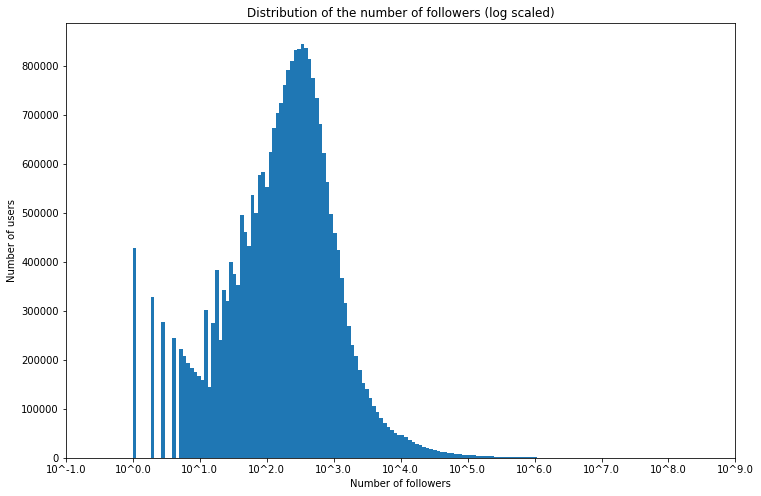

In [11]:
plt.hist(bins[:-1], bins=bins, weights=counts)
plt.title('Distribution of the number of followers (log scaled)' )
plt.ylabel('Number of users')
plt.xlabel('Number of followers')
locs, _ = plt.xticks()
labels = ["10^{}".format(l) for l in locs]
plt.xticks(locs, labels);

Surprisingly, the distribution of the exposure and of the number of followers have exactly the same shape! 

We can also note that the median of followers per users is 189.

In [12]:
followers.approxQuantile('followersCount', [.5], .001)

[189.0]

In [10]:
insights_r = insights.where(F.col('count') > THRESHOLD_COUNT)
insights_r.cache();

### Correlation between exposure and number of occurence.

Our intuition is that the exposure of a given hashtag, and its number of occurences are correlated. We wanted to validate this hypothesis by checking it on the dataset.

The first step is to compute spearman correlation coefficient. At 0.45, we can hope for the exposure and the number of occurences to be correlated.

In [143]:
features = insights_r.select("count", "print").rdd.map(lambda row: row[0:])
corr = Statistics.corr(features, method="spearman")

In [144]:
corr[0][1]

0.45635800425950807

However, it is always usefull to check our results visually. We first plot all points (count, print) in a scatter plot.

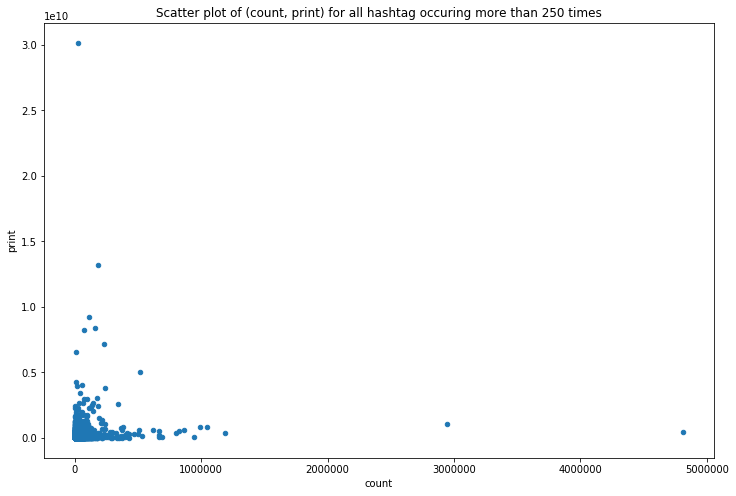

In [216]:
# the projection is small enough to fit in memory
sample = insights_r.select("tag", "count", "print").toPandas()
sample.plot.scatter('count', 'print')
plt.title('Scatter plot of (count, print) for all hashtag occuring more than 250 times');

Most of our data is in the bottom left corner. We will zoom on this corner.

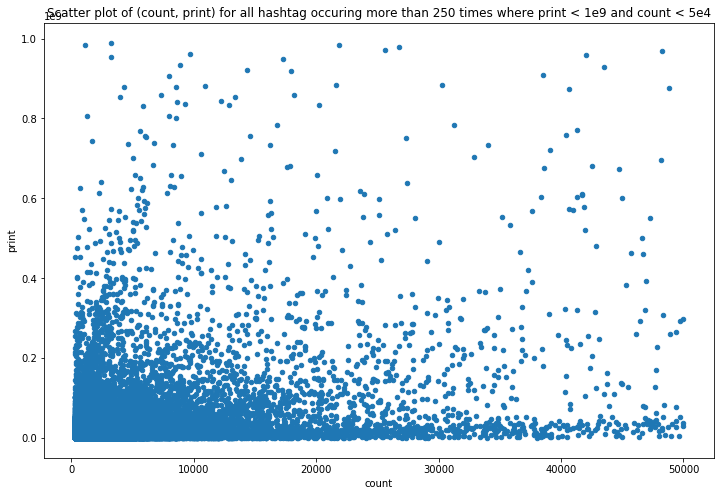

In [223]:
sample = \
    insights_r \
    .where((F.col('count') < 50000) & (F.col('print') < .1 * 1e10)) \
    .select("tag", "count", "print") \
    .toPandas()
sample.plot.scatter('count', 'print')
plt.title('Scatter plot of (count, print) for all hashtag occuring more than 250 times where print < 1e9 and count < 5e4');

Even zoomed in, we can't see a general trend. Most of the points seems to be clustered together.

We have two explanations of why we have not found a correlation between exposure and number of exposure:
- Either this correlation doesn't exists
- Either the exposure we computed is wrong. Right now it is highly dependant on who tweeted a tweet. For exemple, a user with one million follower will impact more the exposure than one thousand users with one hundred followers. However, given that users with a high number of followers are less numerous than other users, as our twitter sampled was uniformly sampled, this problem should not be present as it should have been compensated.

### Distribution of tweets

The distribution of tweets might be interesting to study. We will plot it below.

In [321]:
sum_count_day_pd = \
    insights_r \
    .agg(*[F.sum(F.col(c)).alias(c) for c in count_columns]) \
    .toPandas()

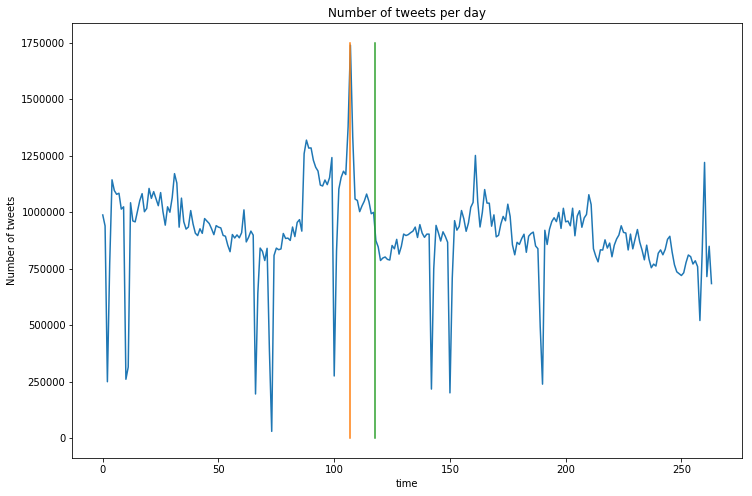

In [476]:
plt.plot(sum_count_day_pd.loc[0].values);
plt.title('Number of tweets per day')
plt.xlabel('time')
plt.ylabel('Number of tweets')
plt.plot([107, 107], [0, 1750000])
plt.plot([117.5, 117.5], [0, 1750000]);

Please keep in mind that some days (or even the full month of June) are missing. For example, here even the point with x coordinate 117 is the 31 may but the point with x coordinate 118 is the first July. This gap is represented by the green line.

The orange line is here to localize the maximum pike.

We also display the number of active hashtags per days. The orange pike is also represented on this graph.

In [319]:
sum_hashtags_day_pd = \
    insights_r \
    .agg(*[F.sum((F.col(c) > 0).cast('long')).alias(c) for c in count_columns]) \
    .toPandas()

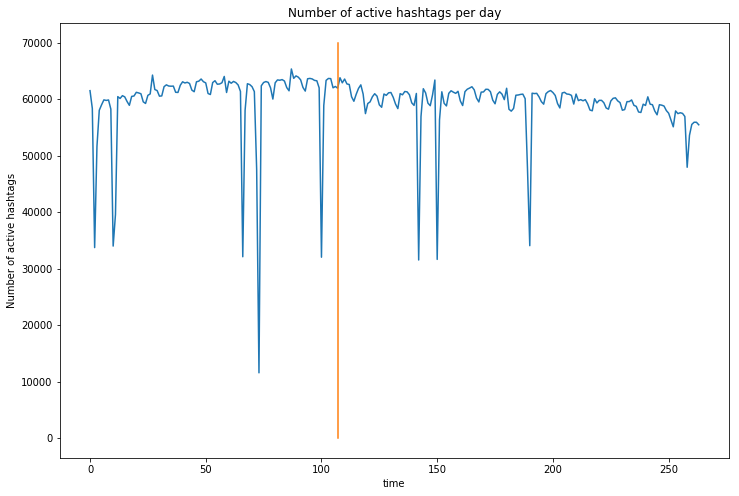

In [477]:
plt.plot(sum_hashtags_day_pd.loc[0].values);
plt.title('Number of active hashtags per day')
plt.xlabel('time')
plt.ylabel('Number of active hashtags')
plt.plot([107, 107], [0, 70000]);

Globally, the number of hashtags of per day is uniform accross 2017, which is something we could have expected. However, the two above graphs are showing some interesting facts:
- Each of the 9 sharp decrease in the number of tweets per day are also present as sharp decrease in the number of hashtags per day, and at the same position. This could hint us that on these days the sampling, or the transfer of the dataset had a problem.
- The maximum pike in the number of tweets per day is not visible on the second graph. This hints us toward a few hashtags which are more populars than others.

First we start by localizing the day where the pike occurs:

In [479]:
sum_count_day_pd.T[sum_count_day_pd.T[sum_count_day_pd.T.columns[0]] == sum_count_day_pd.T.max()[0]]

,0
05_count_21,1739101


This pike is on the 21st May 2017. After a quick search, we found out that billboard awards (or BBMAS) occured on the 22nd May 2017. However, when creating our hashtag insights, we converted dates to a datetime object which internally express times in UTC. It could be possible that due to timezones the event overlapped on the 21st May 2017 in UTC timezone.

We then select tweets which were twitted on this day.

To check our hypothesis, we select the hashtags tweeted on the 21st as well as on the 22nd and the 20th.

In [489]:
tags_25_21 = \
    insights \
    .where(F.col('05_count_21') > 0) \
    .select('tag', 'count', 'print', '05_count_21', '05_print_21') \
    .toPandas()
tags_25_22 = \
    insights \
    .where(F.col('05_count_22') > 0) \
    .select('tag', 'count', 'print', '05_count_22', '05_print_22') \
    .toPandas()
tags_25_20 = \
    insights \
    .where(F.col('05_count_20') > 0) \
    .select('tag', 'count', 'print', '05_count_20', '05_print_20') \
    .toPandas()

We now plot the most tweeted hashtags for the three days.

In [495]:
tags_25_21.sort_values('05_count_21', ascending=False).head(10)

,tag,count,print,05_count_21,05_print_21
187553,BTSBBMAs,2943069,1054566200,322129,113463234
139761,BBMAs,865828,591855353,114432,101628505
69683,topBBMAs,118118,46488146,37170,13344811
83831,NickiBBMAs,116431,101035896,33552,18085160
199892,izmirescort,4813484,473402849,26326,1520893
51766,PREMIOSMTVMIAW,798094,366569035,25916,8264276
82408,JustinBBMAs,201398,216706800,15545,15070525
218094,VeranoMTV2017,336345,33994283,14361,1640455
59799,MTVINSTAARVICICONTE,212576,138159858,11957,5547702
165441,TeamMendes,22173,12917511,10444,5081377


In [492]:
tags_25_22.sort_values('05_count_22', ascending=False).head()

,tag,count,print,05_count_22,05_print_22
144982,BBMAs,865828,591855353,112071,177617187
194720,BTSBBMAs,2943069,1054566200,51518,29270483
53751,PREMIOSMTVMIAW,798094,366569035,27395,6675467
275256,BTS,1048438,856258406,23001,16387958
147990,MTVSUPERCAEYOSS,215493,2772793,18070,118737


In [493]:
tags_25_20.sort_values('05_count_20', ascending=False).head()

,tag,count,print,05_count_20,05_print_20
190128,BTSBBMAs,2943069,1054566200,214983,71259469
52353,PREMIOSMTVMIAW,798094,366569035,30471,8312065
141979,BBMAs,865828,591855353,29334,10338314
202850,izmirescort,4813484,473402849,24796,1184615
85101,NickiBBMAs,116431,101035896,16035,8061344


Unsurprinsgly hashtags linked to BBMAS' are the hashtags the most tweeted on these days. Moreover, the most tweeted hashtags on the 21st are more tweeted than the ones on the 20th or the 22nd and by far. Add to that that a tweet can contain several hashtags, and that it is likely that a user have tweeted a tweet with several hashtags (ex: #BBMAs and #JustinBBMAs) and we can understand the pike on the 21st.

## Analyze of the most tweeted hashtags

In this part we want to vizualize the most important hashtags.

Our first step is to define a function which will allow us to vizualize an insights of a given hashtags against the distribution of this insights for all hashtags. 

In [69]:
def plot_tags(insight, tags, tag_per_plot = 3):
    """Plot an graph for insight [insight] and 
    showing were [tags] are located compared to the distribution."""
    
    # First we adjust the top of our lines
    top = 7000
    if insight == "exposure_per_tweet":
        top = 3300
    elif insight == "print":
        top = 4000
        
    n_plots = len(tags) // tag_per_plot
    
    
    plt.figure(figsize=(15, 5 * ((n_plots + 1) // 2)))
    
    for i in range(0, len(tags), tag_per_plot):     
        subtags = tags[i : i + tag_per_plot]
        plt.subplot(n_plots // 2 + n_plots % 2, 2, i//tag_per_plot + 1)
        plt.tight_layout()    
    
        # We plot our distribution
        insights_strip_pd[insight].map(np.log10).plot.hist(bins=150)
        
        for _, row in subtags.iterrows():
            lines = plt.plot([np.log10(row[insight])] * 2, [0, top], label=row['tag'])
        plt.xlabel(insight + ' (log)')
        plt.legend()

We augment our dataset with a new insight called `exposure_per_tweet` derived from `print` and `count`. This insight corresponds to the average exposure per tweet a hashtag has. It is usefull to approximate if an hashtags is artificially tweeted about by a bot (in which case `exposure_per_tweet` will be low) or if it is more human like. If `exposure_per_tweet` is near, or higher than 190 (see the distribution of the number of followers), then it is likely that this tweet was tweetted by human users.

As the subset of the insights we will be using is small, we can store it inside a pandas dataframe.

In [14]:
insights_strip_pd = \
    insights_r \
    .select('tag', 'count', 'print') \
    .withColumn('exposure_per_tweet', F.col('print')/F.col('count')) \
    .where((F.col('exposure_per_tweet') > 1) & (F.col('print') > 1)) \
    .toPandas()

The median of `exposure_per_tweet` is 2200:

In [97]:
insights_strip_pd.exposure_per_tweet.median()

2199.4175627240143

The 10 most tweeted hashtags are the following:

In [15]:
count_10largest = insights_strip_pd.nlargest(10, 'count')
count_10largest

,tag,count,print,exposure_per_tweet
90274,izmirescort,4813484,473402849,98.349314
84755,BTSBBMAs,2943069,1054566200,358.321942
84887,MTVHottest,1188991,408684695,343.723960
118950,BTS,1048438,856258406,816.699133
117811,방탄소년단,992185,805900903,812.248626
6014,bucaescort,946477,103901599,109.777204
63372,BBMAs,865828,591855353,683.571510
78904,GOT7,825628,559620828,677.812317
23784,PREMIOSMTVMIAW,798094,366569035,459.305589
103194,เป๊กผลิตโชค,691987,74748357,108.019886


We can find several tweets about the BBMAS. It is interesting to note that both `GOT7` and `BTS` refers to music groups. The hashtag for game of thrones is `got7`, not `GOT7`.

We export this table to JSON for future use.

In [99]:
count_10largest.to_json('exports/10-most-used.json', orient='records')

We also export the timeline of `#BTS` and `#BTSBMMAs` to find some correlation and spikes.

In [12]:
insights_top10 = insights.where(F.col('count') >= 600000).toPandas()

In [ ]:
def one_insight(df, hashtag):
    """Returns insight about a given hashtag."""
    return df.filter(df.tag == hashtag).first()

insight = one_insight(df, 'BTS')

In [51]:
insight_bts = insights_top10.loc[13]
insight_btsbbmas = insights_top10.loc[7]

In [54]:
def export_insight(path, insight, only_insight_type='count'):
    """Exports count or print insights for a given hashtag into JSON."""
    import datetime

    tuples = []
    for (colname, coltype) in insights.dtypes:
        # Only consider the daily insights columns.
        if colname in ['tag', 'count', 'print']:
            continue
        
        month, insight_type, day = colname.split('_')
        if insight_type != only_insight_type:
            continue
        
        month = int(month)
        day = int(day)
        tuples.append((datetime.date(2017, month, day), insight[colname]))
    
    tuples.sort()
    dates = []
    values = []
    for date, value in tuples:
        dates.append(date.strftime('%d %b. %Y'))
        values.append(value)

    # Convert the series to a DataFrame and export to JSON.
    series = pd.DataFrame({'date': dates, 'count': values})
    series.to_json(path, orient='records')

In [55]:
export_insight('exports/bts-day.json', insight_bts)
export_insight('exports/btsbbmas-day.json', insight_btsbbmas)

We know compare the insight `exposure_per_tweet` of these hashtags against the distribution of `exposure_per_tweet`. It is likely that `bucaescort`, `izmirescort` and `เป๊กผลิตโชค` are shared by bots.

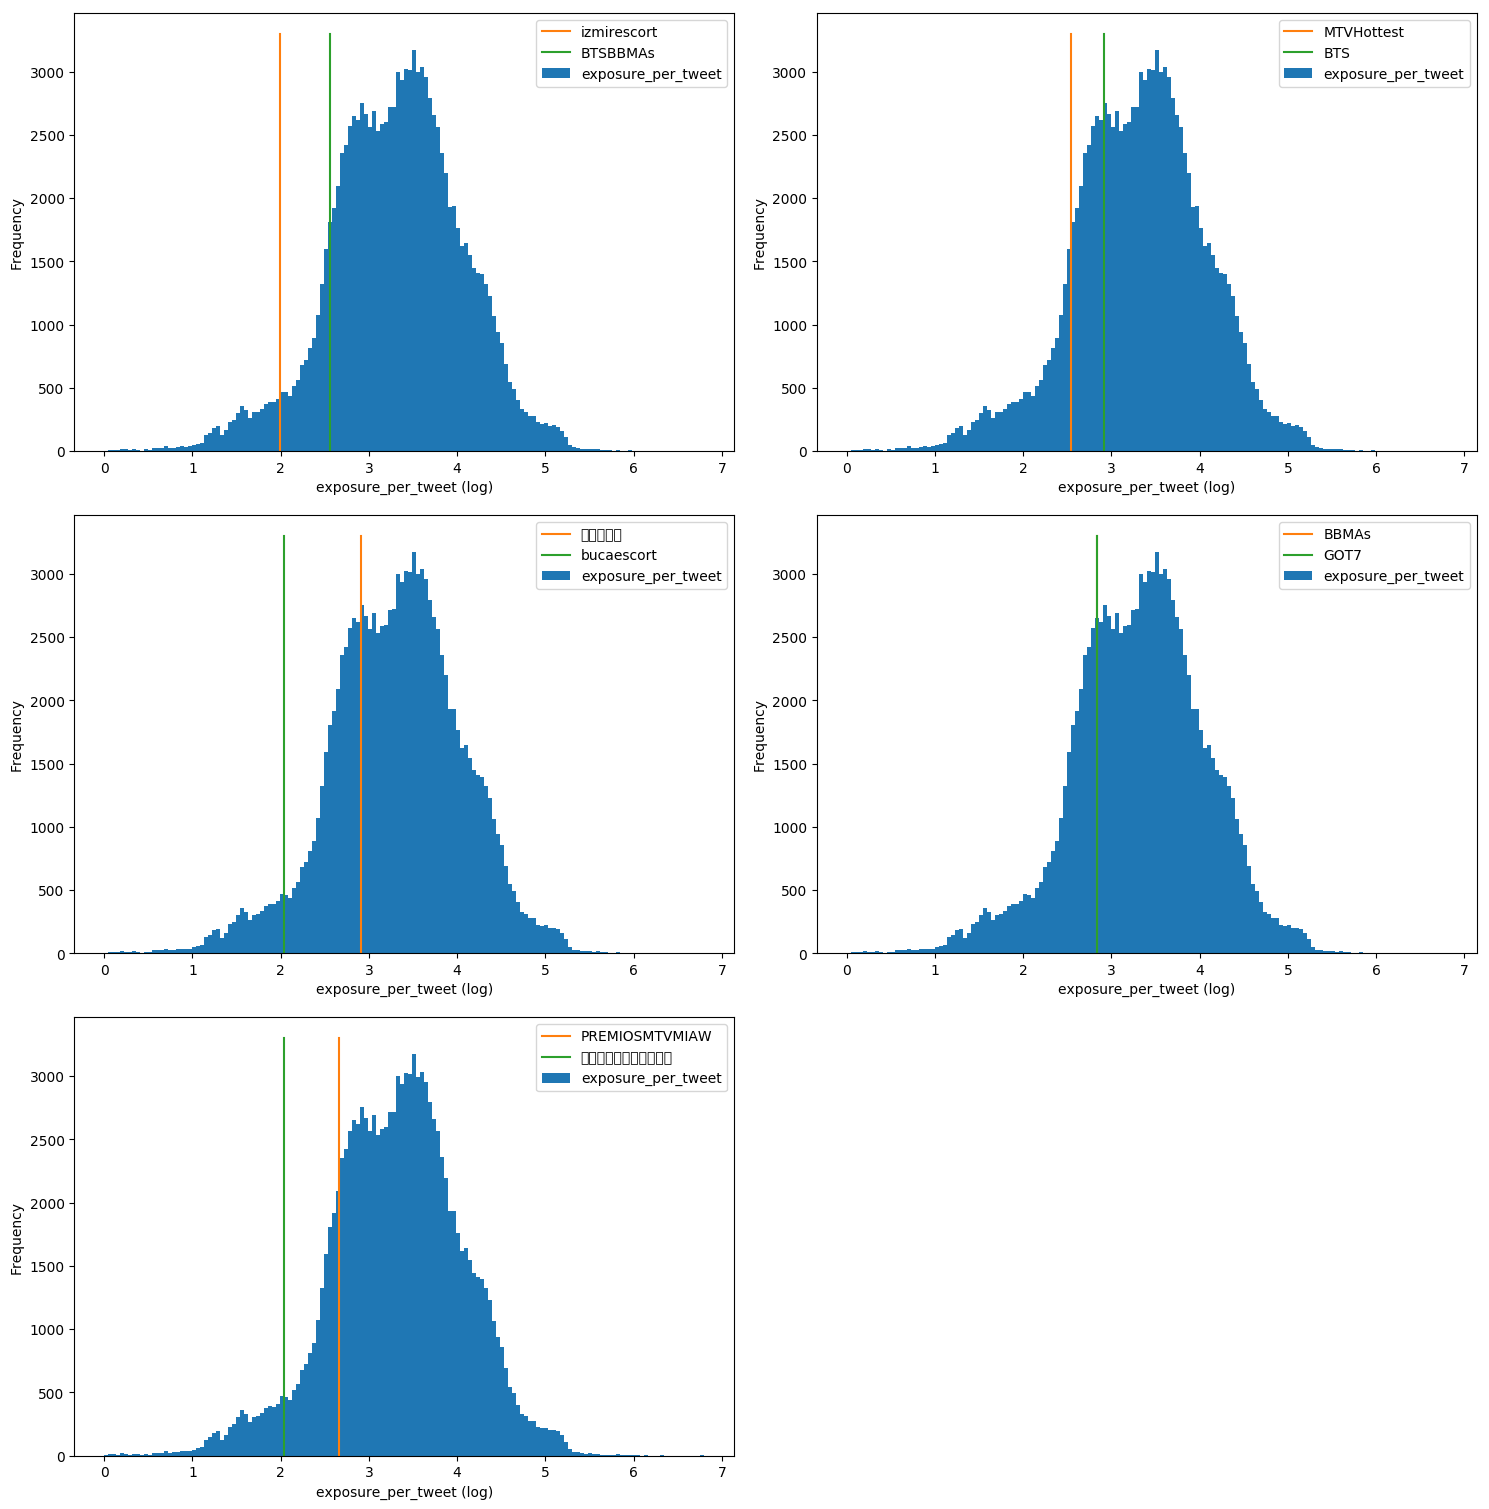

In [62]:
plot_tags('exposure_per_tweet', count_10largest, 2)

By observing the 10 hashtags with the highest `exposure_per_tweet`, we can see that they are not, at the exception of `セブンイレブンの日` among the most tweeted hashtags. The fact that their `exposure_per_tweet` might be because the sampling contains a tweet made by a popular user, and as the number of occurences of these hashtags is low, it distort the `print` insight.

In [63]:
exposure_per_tweet_10largest = insights_strip_pd.nlargest(10, 'exposure_per_tweet')
exposure_per_tweet_10largest

,tag,count,print,exposure_per_tweet
61266,feeltrueemojipower,391,2453009424,6.273681e+06
87397,mmda,816,1672181826,2.049242e+06
31778,NDTVTopStories,325,454400797,1.398156e+06
43302,TacoEmojiEngine,824,1135826570,1.378430e+06
65618,セブンイレブンの日,26477,30153551665,1.138858e+06
67677,ProgramaDaSabrina,463,474769403,1.025420e+06
106903,DID6,1099,1070017137,9.736280e+05
23880,albumrelease,533,502389707,9.425698e+05
57441,ElshintaNewsAndTalk,434,402680272,9.278347e+05
74775,KASKUSNews,1086,984761228,9.067783e+05


We also export this table for future use.

In [11]:
exposure_per_tweet_10largest.to_json('exports/10-most-expptwt.json', orient='records')

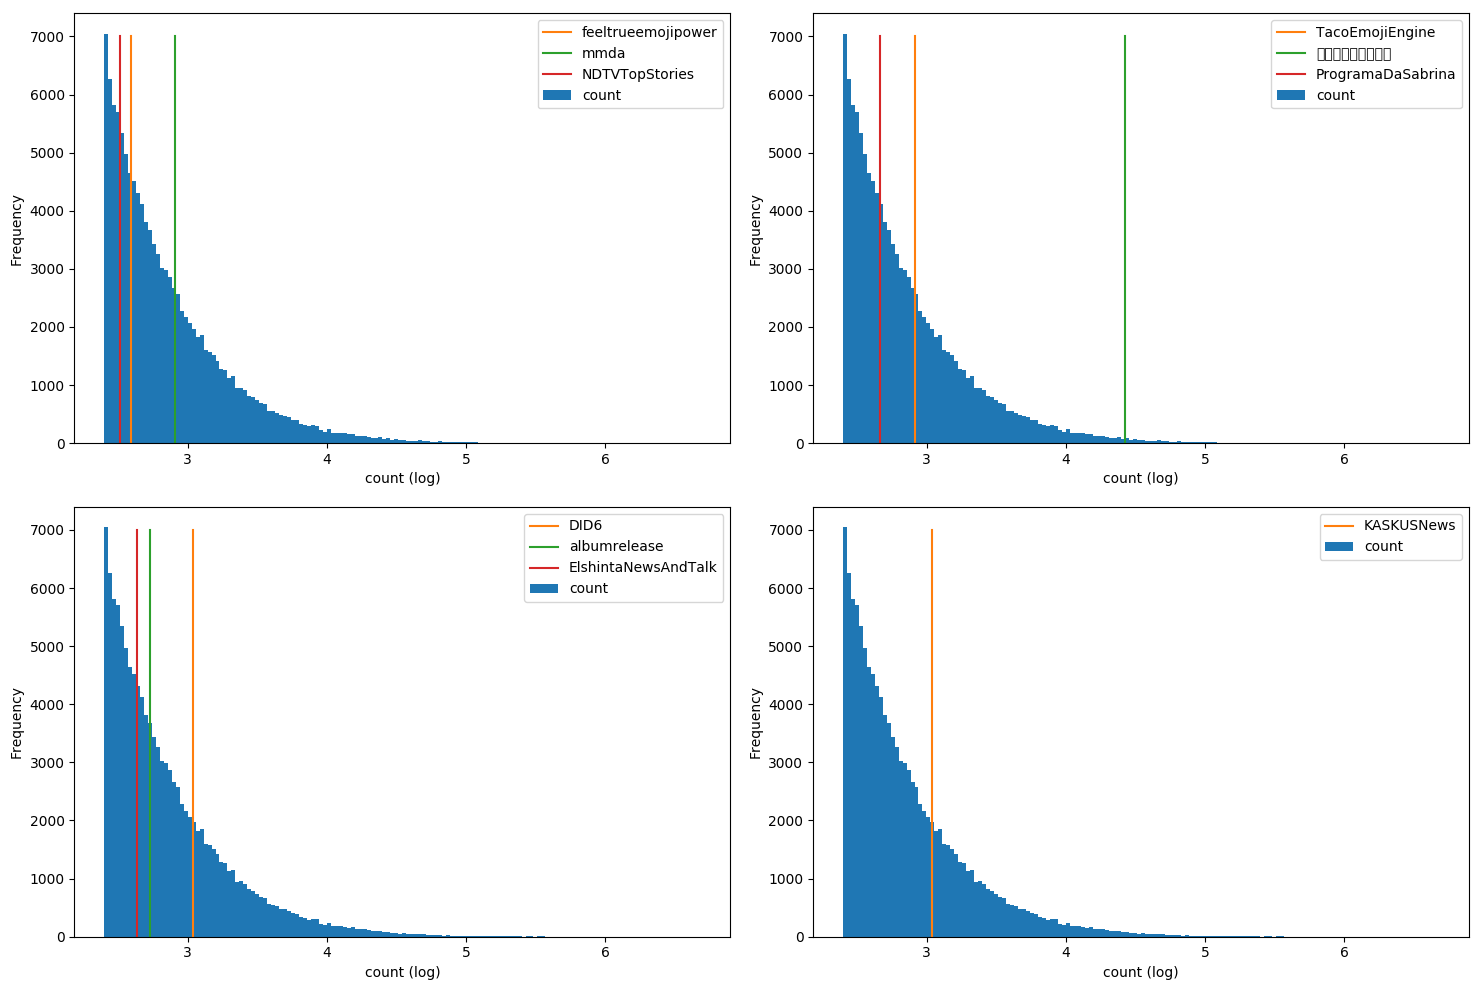

In [64]:
plot_tags('count', exposure_per_tweet_10largest)

We can also vizualize were are situated some hashtags that are linked to the news:

In [65]:
selected_hashtags = \
    insights_strip_pd[insights_strip_pd['tag'].isin(['balancetonporc', 
                         'notmypresident', 
                         'metoo', 
                         'TakeAKnee', 
                         'Third_debate', 
                         'YemenInquiryNow',
                         'got7'])]

A small description of these hashtags:
- #MeToo emerged after the Weinstein affair and is about sexual abuse and harassment
- #balancetonporc is the french version of #MeToo
- #TakeAKnee is comments about about the action of some NFL players kneeling during the national anthem
- #notmypresident is an hashtag of protestation agains Trump. It started a bit earlier, on the 9th november 2016, but it regain some speed in January as Trump was inaugurated
- #Third_debate is about the first debate of the iranian elections. One important aspect is that the Iranian government banned twitter at this point.
- #YemenInquiryNow raised awarness about the humanitarian crisis occuring in Yemen
- #got7 is about the season 7 TV show Game Of Thrones

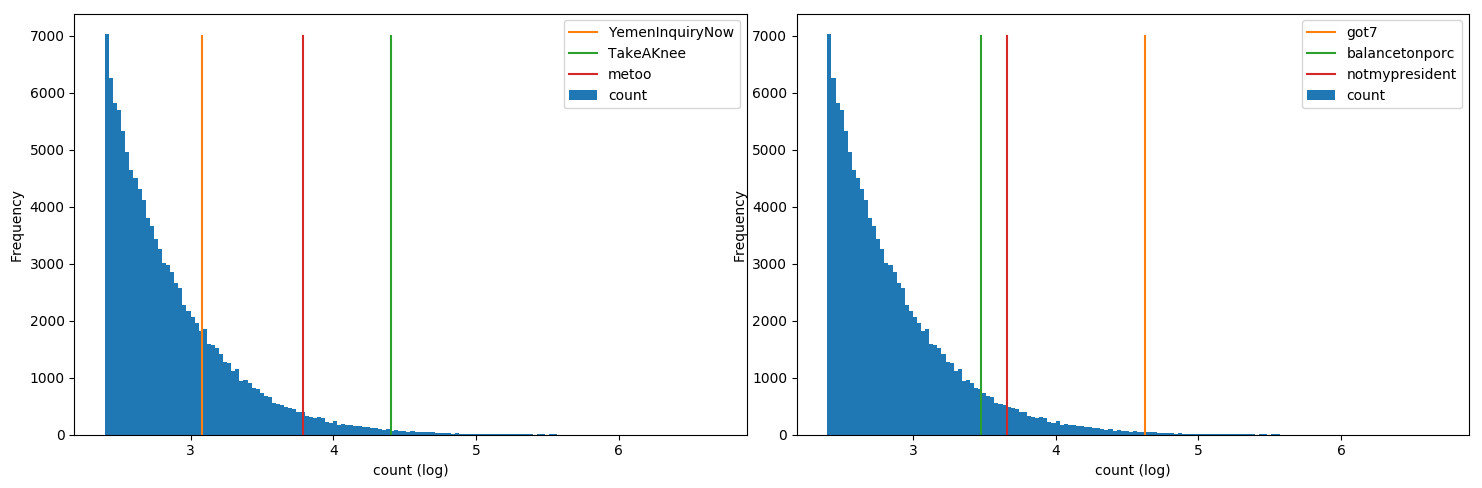

In [73]:
plot_tags('count', selected_hashtags)

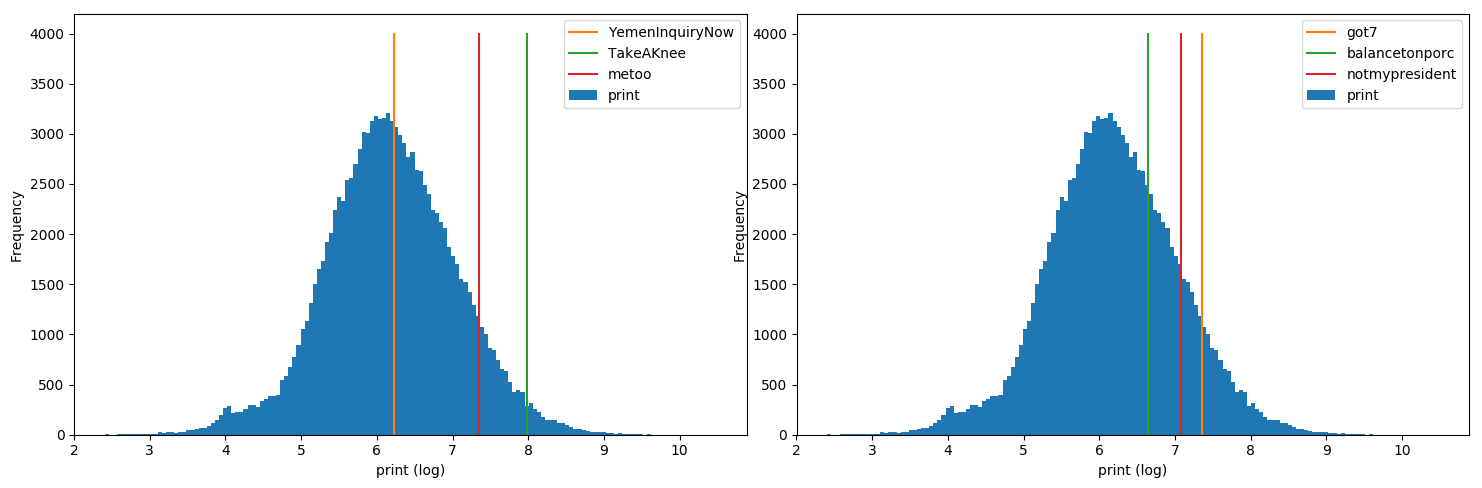

In [67]:
plot_tags('print', selected_hashtags)

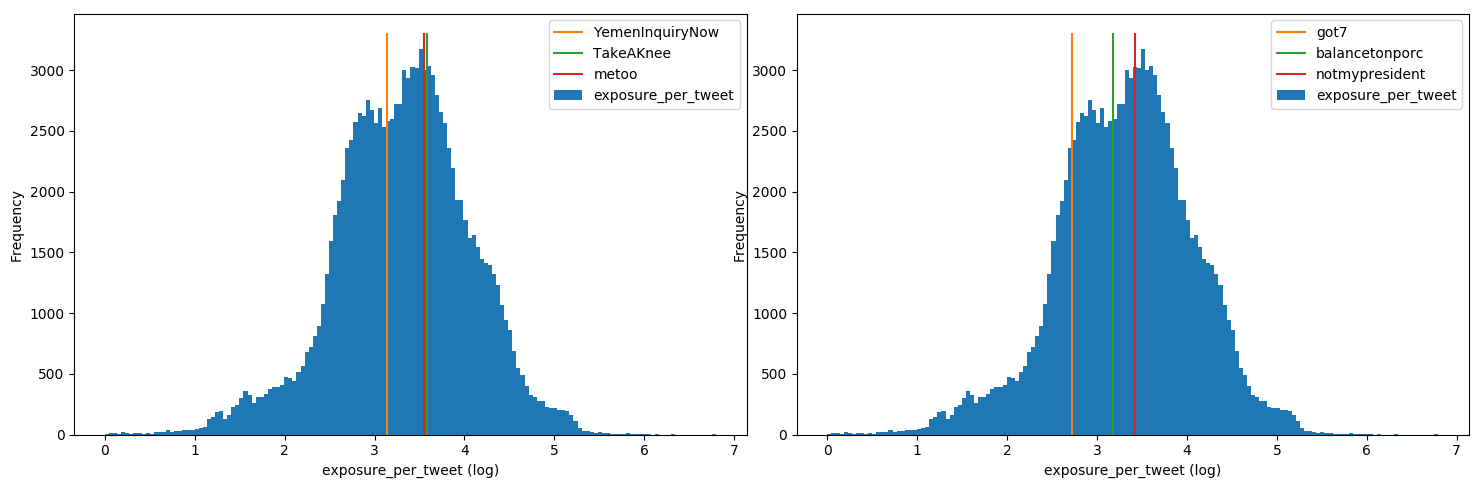

In [68]:
plot_tags('exposure_per_tweet', selected_hashtags)

These hashtags are quite popular and all features a higher than average exposure. They all seems to have been twitted by human mostly. Also all of them, excluding #got7 have an higher exposure_per_tweet than normal. This could be explained by the fact that hashtags linked to the actuallity are more likely to be tweeted by news channels, and retweeted by politics or popular users having several million of followers.

In [596]:
got7 = insights_compressed.where(F.col('tag') == "got7").toPandas()

In [ ]:
izmirescort

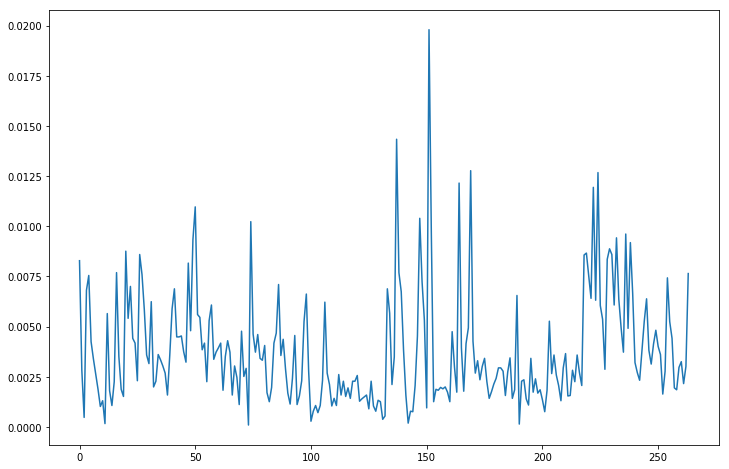

In [597]:
plt.plot(got7.count_daily.values[0])

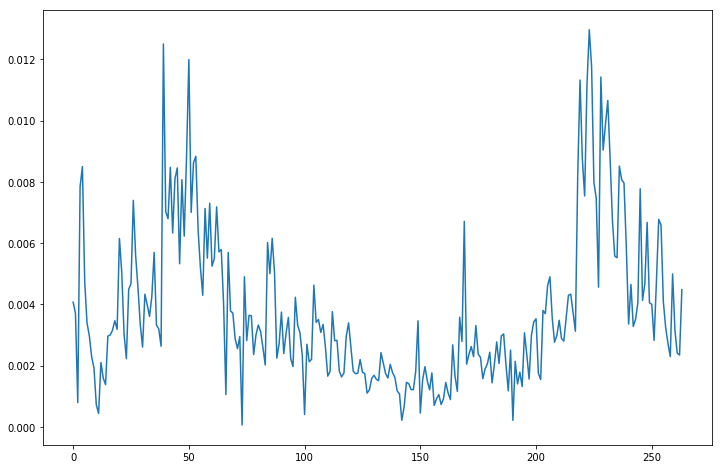

In [594]:
#plt.plot(got7.print_daily.values[0])
plt.plot(got7.count_daily.values[0])

## Analyze of the alphabet used in the hashtag

One interesting point to study is to study if the country of the hashtags impact the number of occurences. In our insights we don't have access to the language of the tweet. However, as the hashtags are some UTF-8 strings, we can extrapolate the alphabet (cyrillic, arabic, chinese, japanese, korean, latin) used. The alphabet itself is a good approximation of the language.

In [77]:
import re
# we first define the character range for the different alphabet in utf-8
cyrillic = "[\u0400-\u04FF\u0500-\u052F]"
arabic = "[\u0600-\u06FF\u0750-\u077F\uFB50-\uFDFF\uFE70-\uFEFF]"
chinese = "[\u2E80-\u2EFF\u3000-\u303F\u3100-\u312F\u31A0-\u31BF\u31C0-\u31EF\u3200-\u32FF\u3300-\u33FF\u3400-\u4DBF\u4E00-\u9FFF\uF900-\uFAFF\uFE30-\uFE4F]"
japanese = "[\u3040-\u309F\u30A0-\u30FF\u31F0-\u31FF]"
korean = "[\u1100-\u11FF\u3130-\u318F\uAC00-\uD7AF]"
re_cyrillic = re.compile(cyrillic, re.UNICODE)
re_arabic = re.compile(arabic, re.UNICODE)
re_chinese = re.compile(chinese, re.UNICODE)
re_japanese = re.compile(japanese, re.UNICODE)
re_korean = re.compile(korean, re.UNICODE)


def approximateCountry(tag):
    """ Given a string [tag], return a string corresponding to the alphabet used"""
    if re_cyrillic.search(tag) is not None:
        return "cyrillic"
    elif re_arabic.search(tag) is not None:
        return "arabic"
    elif re_chinese.search(tag) is not None:
        return "chinese"
    elif re_japanese.search(tag) is not None:
        return "japanese"
    elif re_korean.search(tag) is not None:
        return "korean"
    else:
        return "latin"
    
udfapproximateCountry = F.udf(approximateCountry, StringType())

In [82]:
insights_alphabet = insights_r.withColumn("alphabet", udfapproximateCountry(F.col('tag')))

We first compute the overall proportion of hashtags made in each alphabet.

In [84]:
count = insights_alphabet.count()
proportions = \
    insights_alphabet \
    .groupby('alphabet') \
    .agg(F.count(F.lit(1)) / count) \
    .toPandas()

In [90]:
proportions['alphabet'] = proportions['alphabet'].apply(str.capitalize)

In [91]:
proportions

,alphabet,(count(1) / 119557)
0,Korean,0.093320
1,Cyrillic,0.004776
2,Chinese,0.097385
3,Arabic,0.124376
4,Japanese,0.039655
5,Latin,0.640489


We now compute the proportion of hashtags made in each alphabet for an increasing threshold on the number of occurences of hashtag.
More simply said, we want to know the proportion of hashtags written in chinese among all hashtags occuring more than 250 times, then the proportion for hashtags occuring more than 500 times, etc...

In [92]:
language_df = pd.DataFrame()
thresholds = list(range(250, 100001, 1000))
for t in thresholds:
    filtered = \
        insights_alphabet \
        .where(F.col('count') > t) 
    count = filtered.count()
    temp = \
        filtered \
        .groupby('alphabet') \
        .agg((F.count(F.lit(1)) / count).alias('count_' + str(t))) \
        .toPandas()
    temp['alphabet'] = temp['alphabet'].apply(str.capitalize)
    language_df = pd.concat([language_df, temp.set_index('alphabet').T], ignore_index=True, sort=True)

In [93]:
language_df = language_df.fillna(0)
language_df['threshold'] = thresholds

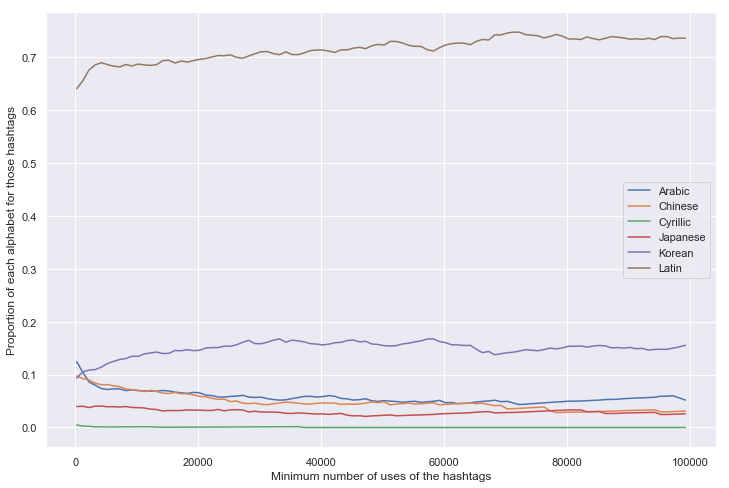

In [94]:
language_df.plot(x='threshold', y=[col for col in language_df.columns if col != 'threshold'])
plt.xlabel('Minimum number of uses of the hashtags')
plt.ylabel('Proportion of each alphabet for those hashtags');

Interestingly, the alphabet used have nearly no influence on the popularity (defined as the count) of an hashtag. The proportion of hashtags written in chinese (for example) is nearly always constant.
We also should notice that the higher the threshold increase, the lower the count of hashtag occuring more than the threshold are.

## Clustering to find similar trends

In the last part of the analysis of hashtags we wanted to explore how to find similar hashtags according to the evolution of the number of occurences in the time. Intuitively, we would want to regroup together hashtags being tweeted every day, regroup together hashtags having one spike of activity... In other words, we want to do some clustering.

However, in our case we are dealing with time series. The euclidean distance will not work correctly, and we want a better metric. The solution is to use dynamic time warping. Dynamic time warping is a metric used to measure the similarity of two temporal sequence. The algorithm behind it is very similar to the levenshtein distance for words. We will be using the implementation fastdtw of the dtw algorithm.

Unfortunately, we can't use kmeans to do our clustering as it is [not efficient with dtw](https://stats.stackexchange.com/questions/131281/dynamic-time-warping-clustering). Pyspark does not have a method for more general clustering, thus prohibiting it to launch our clustering on the whole dataset.

To avoid these limitations we decided to proceed in two steps:
- First we compute the clustering using hierarchical clustering on a subset $X$ of our dataset
- Secondly we extrapolate the clustering of our dataset using knn: for each hashtag, we assign it to the cluster of its nearest neighbors according to dtw.

The first step is to create a sample of our dataset. We are sampling .5% of the dataset without replacement, which is equivalent to 600 hashtags.

In [12]:
sample_ic_pd = insights_compressed.where(F.col('count') > 250).sample(False, .005).toPandas()

In [6]:
from sklearn.cluster import KMeans, AgglomerativeClustering #For clustering
from scipy.spatial.distance import pdist, squareform
from fastdtw import fastdtw

We then compute the distance matrix of our subset. The distance matrix is a matrix where entry $ij$ is the dtw distance between hashtag $i$ and hashtag $j$

In [27]:
values = sample_ic_pd.count_daily.map(lambda x: np.array(x)).values

In [77]:
dist_matrix =\
    squareform(pdist(
        pd.DataFrame(values.tolist(), index=sample_ic_pd.index), 
        lambda a, b : fastdtw(a, b)[0]))

We then compute the clustering using our precomputed distance matrix. We are looking for 10 clusters.

In [99]:
def doAgglomerative(X, nclust=2):
    model = AgglomerativeClustering(n_clusters=nclust, affinity = 'precomputed', linkage = 'average')
    labels = model.fit_predict(X)
    return labels

labels = doAgglomerative(dist_matrix, 12)

We visualize the output by plotting the time series of 5 hashtags per clusters:

In [131]:
def xlabel_to_dates():    
    dates = [datetime.date(2017, month, day).strftime('%d %b. %Y') for (month, day) in count_days]
    locs, _ = plt.xticks()
    labels_x = [dates[int(l)]  if l >= 0 and l < len(count_days) else "" for l in locs]    
    plt.xticks(locs, labels_x)

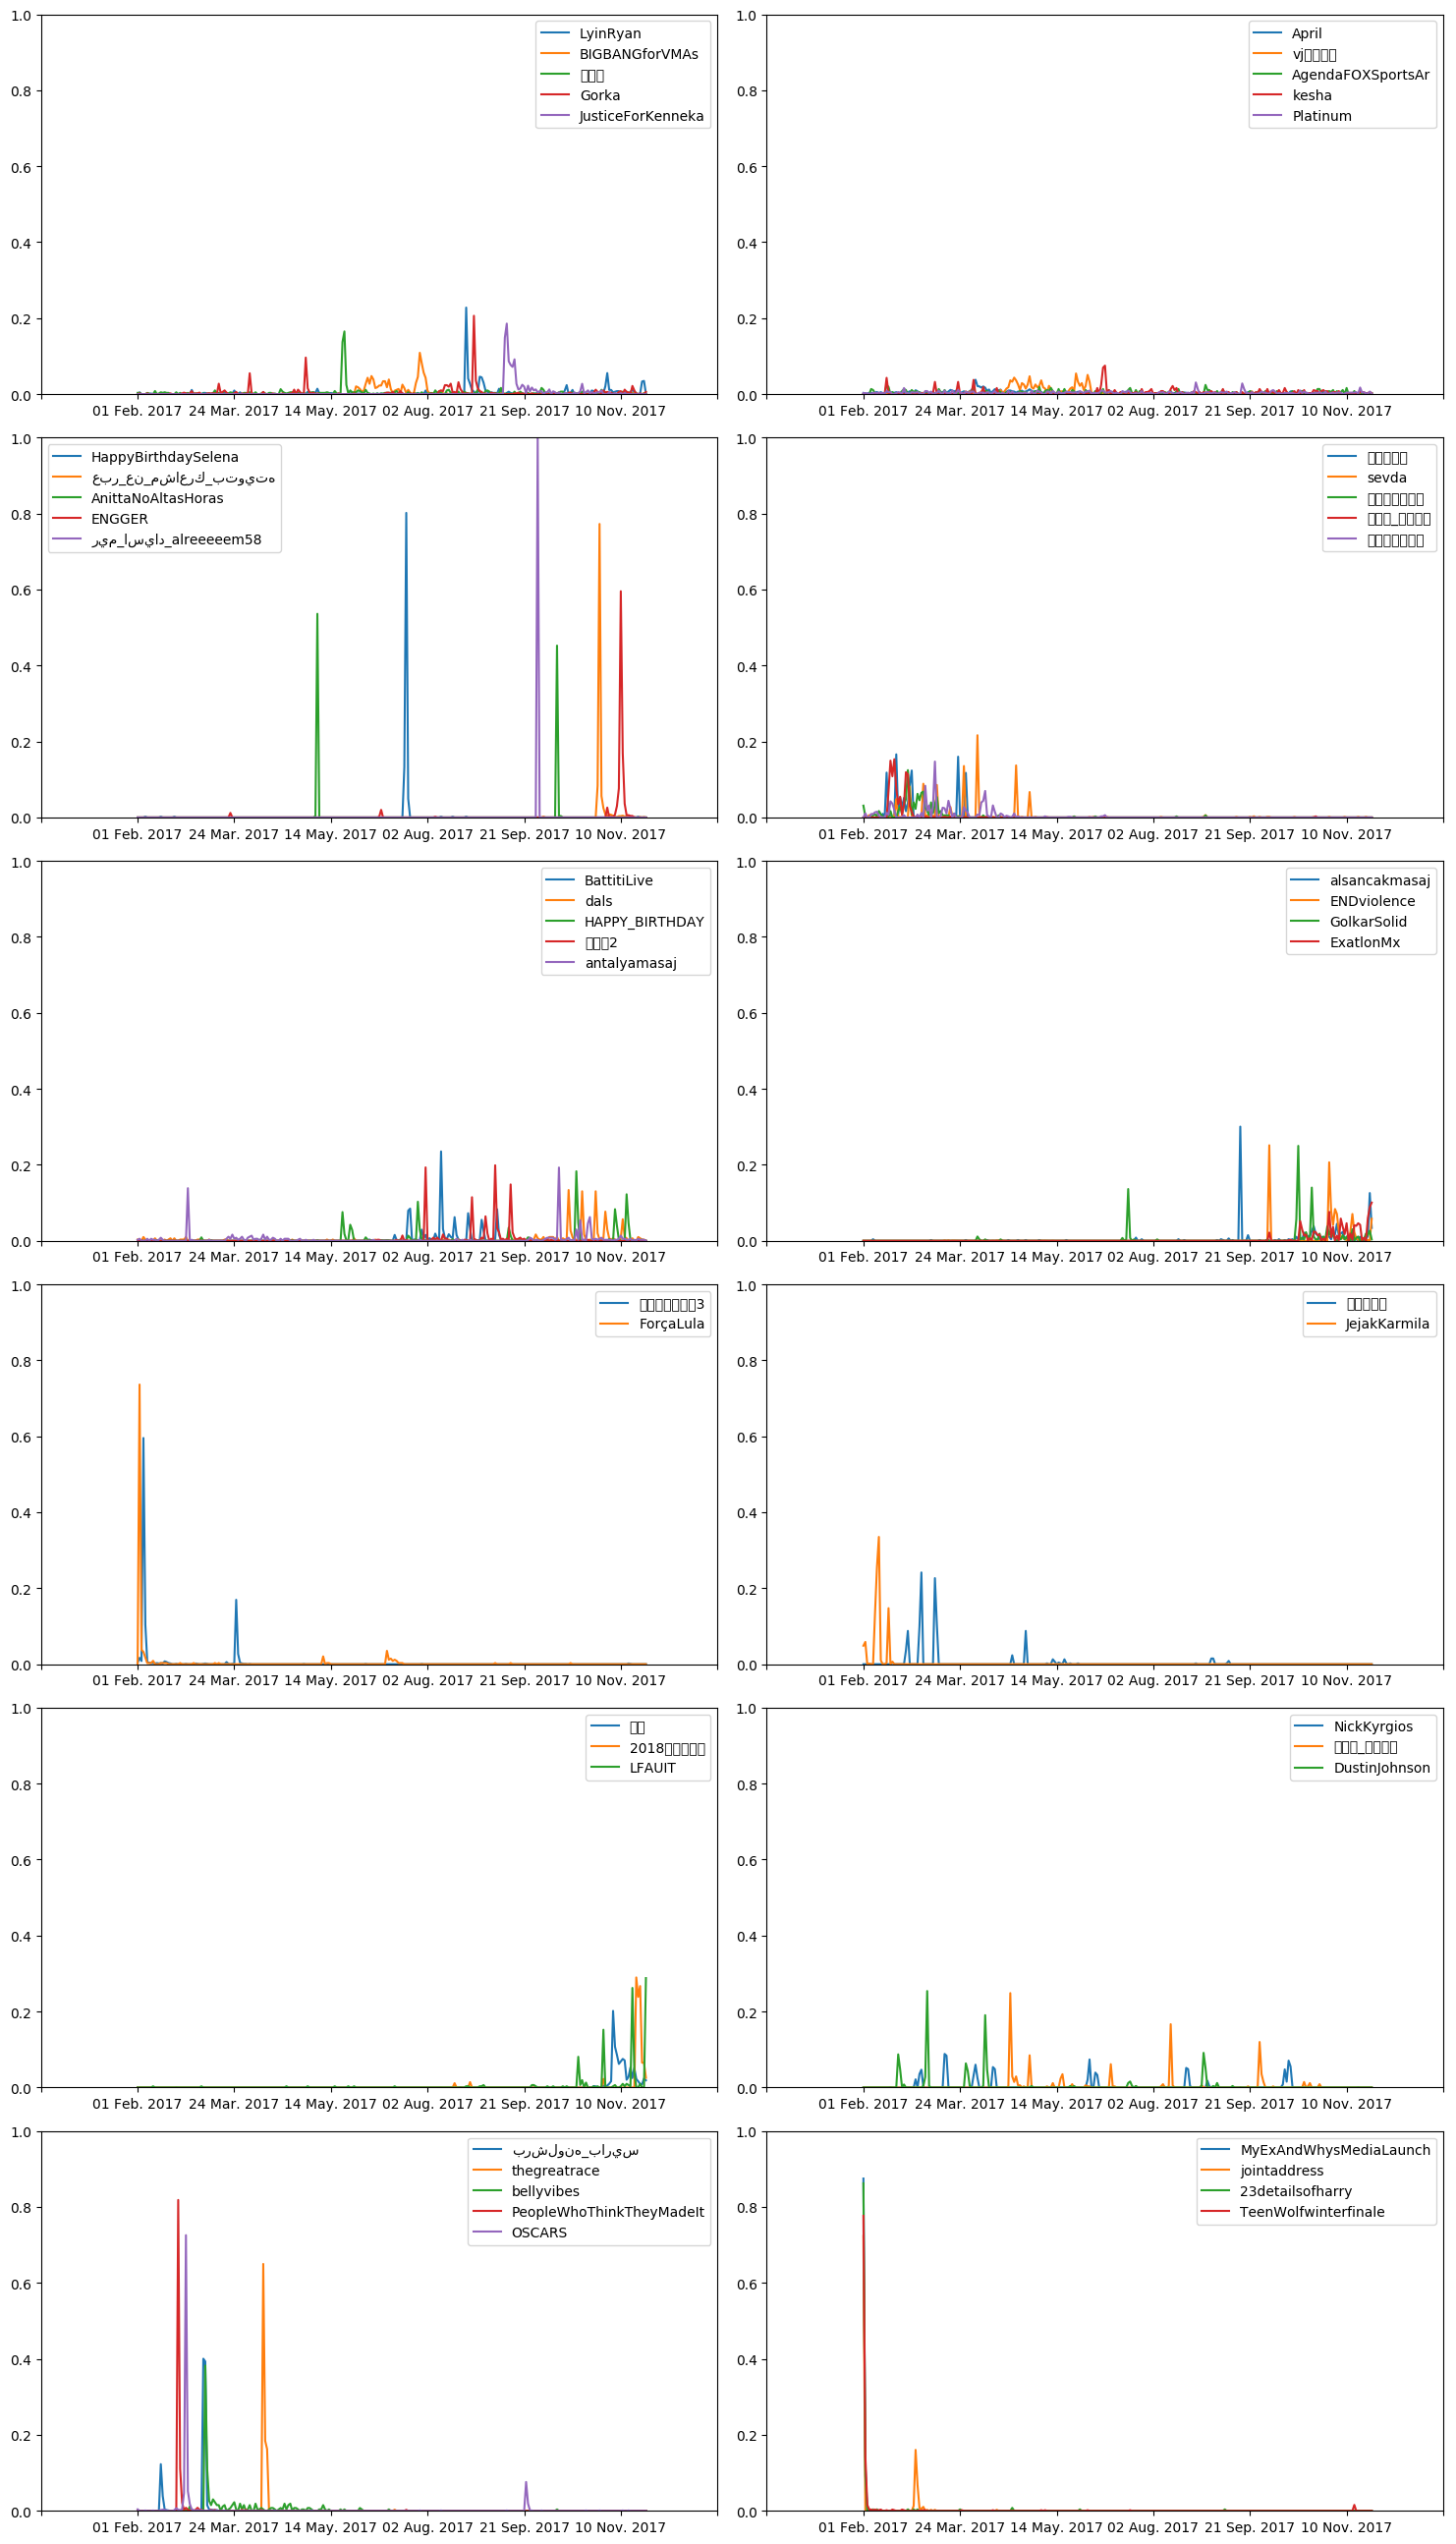

In [136]:
import datetime

labeled_sample = sample_ic_pd
labeled_sample["label"] = labels

N = len(set(labels))
plt.figure(figsize=(15, 4 * (N+1) // 2))
for i in range(N):
    plt.subplot((N + 1) // 2, 2, i + 1)
    plt.tight_layout()
    
    plt.ylim(0, 1)
    which = labeled_sample.label == i
    cluster_representants = labeled_sample[which].sample(n=min(5, labeled_sample[which].shape[0]), replace=False)
    for _, row in cluster_representants.iterrows():
        pd.Series(row.count_daily).plot(label=row.tag)
    
    xlabel_to_dates()
    
    plt.legend();

Unfortunately, we haven't found how to implement k-nn efficiently on the spark dataset. Nethertheless, you can find below our ideas:
- If we want to do 1-nn, we can first do a cartesian product between the dataset $Y$ and our sample $X$, then for each entry compute the dtw distance between the two, then groupby along the tag of the entry in $Y$ and pick the minimum value
- If we want to do k-nn for an other k, we can take the first 10000 entries of the dataset, convert them to a pandas dataframe, use sklearn's k-nn implementation, and repeat for the next 10000 entries.

We also tried do clustering with the euclidean distance by using kmeans. The intuition behind it is fact it should be efficient to find co-occuring hashtags. Unfortunately, we obtained bad results when we tried on the full year, but on a month results are much more pertinent as we can see below: 

In [3]:
# We load the month of november and we transform it a bit
hashtags11 = spark.read.parquet('data/hashtags_insights_11.parquet')
hashtags11_pd = hashtags11.filter(F.col('count') > 100).toPandas()
print_columns = [x for x in hashtags11_pd.columns if 'print' in x]
count_columns_days = [x for x in hashtags11_pd.columns if 'count_' in x]
hashtags11_pd = hashtags11_pd.drop(print_columns, axis=1)

x = hashtags11_pd['count']
for c in count_columns_days:
    hashtags11_pd[c] /= x

In [4]:
def doKmeans(X, nclust=10):
    model = KMeans(nclust)
    model.fit(X)
    clust_labels = model.predict(X)
    return clust_labels

In [9]:
labels = doKmeans(hashtags11_pd[count_columns_days], 5)

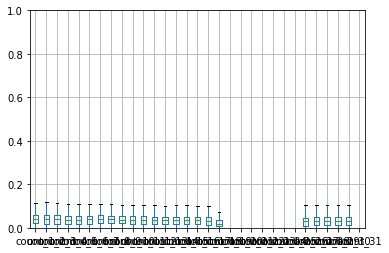

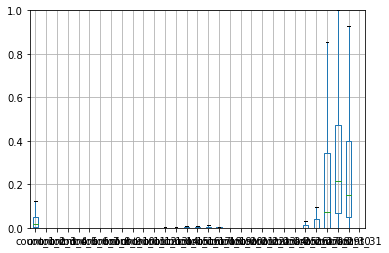

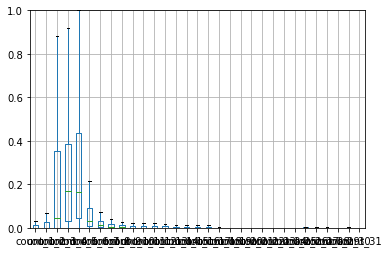

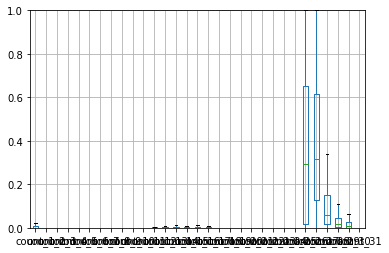

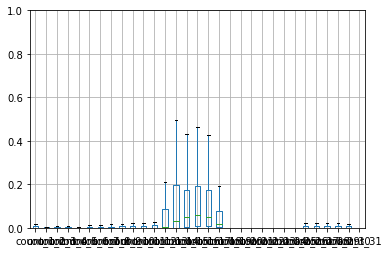

In [11]:
# We plot each clusters using a boxplot
for i in range(5):    
    plt.figure(i)
    hashtags11_pd[(labels == i)].boxplot(count_columns_days, showfliers=False)
    plt.ylim(0, 1)

We also can get 5 tags per cluster:

In [21]:
for i in range(5): 
    tags = hashtags11_pd[(labels == i)].sample(n=min(5, hashtags11_pd[(labels == i)].shape[0]), replace=False)
    print(i, tags.tag.values)

0 ['びびび' '愛' 'Hカップ' 'anniversary' 'Japón']
1 ['GolpeDeTimonActivado' 'Despacito' 'InfinityWar' 'daehyun' 'Parkjihoon']
2 ['金持ち三条と貧乏粟田口' 'หนังพาไป' 'バズリズム' 'とまコス' 'BibiTattoGames']
3 ['Hunbaek' 'قضيه_دخول_المجلس' 'SuaPiadaMata' 'KathNailsByKCMBAtCloverleaf'
 'のどじまんTHEワールド']
4 ['9วิชาสามัญ' 'MarceloNoHojeEmDia' 'けもフレロッテリア' 'مسکن_مهر' '魔法作ってます']


# Analyze of particular hashtags

In this second part we will speak about the analysis of specific hashtags. We picked two hashtags, `#balancetonporc` (the french version of `#metoo`) and `#notmypresident`. The notebook does not contain the qualitative analysis, which is present in the data story and in the notebook `script/web_export.ipynb`.

## Building our dataset

As this part is about doing a precise analysis of specific hashtags, we can't use the provided cluster anymore. We tried, but the data we could grab from the cluster was far too sampled to do a precise analysis on it (for `#balancetonporc` we got only 3000 tweets from the cluster, but more than 70000 by scrapping twitter). From this point, we add three options:
- Abandon
- Use the Twitter's api. Unfortunately, it is far too limited for crawling tweets in bulk.
- Scrapping.

We chose to go with scrapping by using `twint` (https://github.com/twintproject). After a few days we were able to scrape `#notmypresident`, `#balancetonporc` and `#covfefe` but we didn't had the time to analyze the last one.

Our main scrapping script can be found below:

In [ ]:
import twint

c = twint.Config()
c.Search = "#NotMyPresident"
c.Until = "2016-11-31"
c.Store_json = true
c.Output = "npm.json"

twint.run.Search(c)

We also created a pull request for `twint` to fix a bug (https://github.com/twintproject/twint/pull/308).

## Using pagerank to find important users

As always the first step is to load our data. Here, it is not usefull to load the dataset with spark are we are directly converting it to pandas. However, we are still doing it as it will ease the reproductibility of our analysis on hashtags having more tweets: we just have to sample the pyspark dataframe  before converting it to pandas.

In [2]:
tweets = spark.read.json('balancetonporc.json')

In [3]:
tweets_pd = tweets.toPandas()

In [4]:
tweets_pd['created_at'] = pd.to_datetime(tweets_pd['created_at'], unit="ms")
tweets_pd.head()

,conversation_id,created_at,date,gif_thumb,gif_url,has_parent_tweet,hashtags,id,is_quote_status,is_reply_to,...,retweets_count,tags,time,timezone,tweet,urls,user_id,username,video_thumb,video_url
0,1071507278875033600,2018-12-08 20:50:17,2018-12-08,,,0,[#balancetonporc],1071507278875033600,0,0,...,0,[],21:50:17,CET,Un livreur de pizza qui demande clairement des...,[],777095708692324353,hllelea,,
1,1071495065514721280,2018-12-08 20:01:45,2018-12-08,,,0,[#balancetonporc],1071495065514721280,0,0,...,0,[],21:01:45,CET,J'ai ajouté une vidéo à une playlist @YouTube ...,[http://youtu.be/QYAYnGu_iaw?a],830093777591234560,chouchoue_,,
2,1071483541286993920,2018-12-08 19:15:58,2018-12-08,,,0,[#balancetonporc],1071483541286993920,0,0,...,0,[],20:15:58,CET,#balancetonporc https://www.sudouest.fr/2018/...,[https://www.sudouest.fr/2018/09/05/il-photogr...,882276333291786240,sweetieoparadis,,
3,1071481275528167425,2018-12-08 19:06:57,2018-12-08,,,0,[#balancetonporc],1071481275528167425,0,0,...,0,[],20:06:57,CET,Salut la twitosphère #balancetonporc,[],1042521930849570816,duhippolyte,,
4,1071468524571451392,2018-12-08 18:16:17,2018-12-08,,,0,"[#balancetonporc, #balanceta2000]",1071468524571451392,0,0,...,0,[],19:16:17,CET,Après #balancetonporc il y a #balanceta2000 @L...,[],1065703994,alex____torres_,,


Our goal is to find which users had the most impact on the tweets having a given hashtag. If we think about it, if some tweets of a user are highly retweeted, then he must have had some influence, because he could have made an other user tweet about the hashtag. Google used the same thought when they created the pagerank algorithm to find pertinent webpages: the more links are pointing toward a ressource $X$, the most important $X$ might be.

Henceforth, we have decided to adapt pagerank to the problem of finding the users having the most impact. We model a graph as following:
- Every user $a$ having tweeted about the hashtag is a node
- Their is an edge from $a$ to $b$ if and only if $a$ retweeted $b$.
We then compute pagerank other this graph.

### Computing pagerank

We first start by building an `igraph` Graph. Unfortunately `twint` doesn't allow us to know if a tweet is a retweet. However, after playing with it and examining carefully the structure of the page it scrapped, we discovered that if a tweet was indeed a retweet, then the url of the retweeted tweet would be put inside the field 'quote_url'.

In [5]:
def extract_username_from_link(link):
    """ Extract the username from a twitter link (https://twitter.com/USERNAME/...)"""
    return link.split('/')[3]

In [6]:
def build_graph():
    graph = Graph(directed = True)
    edges = pd.DataFrame()
    # first we filter on the user having a non empty quote_url
    retweets = tweets_pd[tweets_pd.is_quote_status == 1]
    # we retrieve the username from the quoted url
    edges['to'] = retweets.quote_url.map(extract_username_from_link)
    edges['from'] = retweets.username
    # we build the graph
    for i, row in edges.iterrows():
        if row['from'] != row['to']:
            graph.add_vertex(row['from'])
            graph.add_vertex(row['to'])
            graph.add_edge(row['from'], row['to'])
    return graph

In [7]:
graph = build_graph()

We can now compute pagerank and add the pagerank rank as attribute to each vertex:

In [8]:
pagerank = graph.pagerank()

In [9]:
graph.vs['pagerank'] = pagerank

Below we ranked the nodes indices according their pagerank rank.

In [10]:
indices = list(range(graph.vcount()))
indices.sort(key=graph.vs['pagerank'].__getitem__, reverse=True)

### Analyzing the results

Who are the most impactfull users?

In [11]:
ranked_users = pd.DataFrame()
ranked_users['name'] = [graph.vs['name'][i] for i in indices]
ranked_users['pagerank'] = [graph.vs['pagerank'][i] for i in indices]

In [12]:
top_20_users = ranked_users.nlargest(20, 'pagerank')

In [13]:
ranked_users.head(20)

,name,pagerank
0,libe,0.002256
1,lemondefr,0.002215
2,Brevesdepresse,0.002173
3,franceinfo,0.002111
4,leLab_E1,0.002048
5,BFMTV,0.002040
6,le_Parisien,0.002022
7,brutofficiel,0.001745
8,Limportant_fr,0.001721
9,Le_Figaro,0.001690


The ten most influent users according to pagerank are accounts of news channel (libe, lemondefr, franceinfo, ...). This is not surprising: these users have a large audience and can reach a large audience. In fact, int the top 20 we got only one user which is not linked to medias: aerkenstone. 

In [14]:
influential_tweets = tweets_pd[tweets_pd['username'].isin(top_20_users.name)]

In [15]:
influential_tweets.groupby('username').count()

,conversation_id,created_at,date,gif_thumb,gif_url,has_parent_tweet,hashtags,id,is_quote_status,is_reply_to,...,retweet,retweets_count,tags,time,timezone,tweet,urls,user_id,video_thumb,video_url
username,,,,,,,,,,,,,,,,,,,,,
aerkenstone,1,1,1,1,1,1,1,1,1,1,...,0,1,1,1,1,1,1,1,1,1
brutofficiel,1,1,1,1,1,1,1,1,1,1,...,0,1,1,1,1,1,1,1,1,1
franceinfo,15,15,15,15,15,15,15,15,15,15,...,0,15,15,15,15,15,15,15,15,15
franceinter,17,17,17,17,17,17,17,17,17,17,...,0,17,17,17,17,17,17,17,17,17
laurentbouvet,9,9,9,9,9,9,9,9,9,9,...,0,9,9,9,9,9,9,9,9,9
lemondefr,7,7,7,7,7,7,7,7,7,7,...,0,7,7,7,7,7,7,7,7,7
libe,9,9,9,9,9,9,9,9,9,9,...,0,9,9,9,9,9,9,9,9,9


Surprisingly, most of the top20 users have no associated tweets in the dataset! This is due to one of the problem of our dataset. Even if we scrapped twitter, we didn't managed to get all tweets. Furthermore, we are doing an over approximation for retweeted tweets. As we are recording the users of all retweeted tweets, it is likely that:
- the retweeted tweet wasn't about #balancetonporc
- we haven't caught the retweeted tweet in our scrapping.

Nevertheless, these tweets are representing a minority of the tweets in our dataset:

In [16]:
tweets_pd.shape

(71479, 32)

It might also be interesting to vizualize when these tweets were tweeted:

In [17]:
def plot_tweets(users):    
    plt.figure(figsize=(15, 15))
    N = len(set(users))
    for i, user in enumerate(users):
        plt.subplot(N // 2 + N % 2, 2, i + 1)
        plt.tight_layout()
        tweets_pd.created_at.dt.floor('d').value_counts().plot()
        user_tweets = tweets_pd[tweets_pd.username == user]
        x = [[tweet.created_at.floor('d')] * 2 for _, tweet in user_tweets.iterrows()]
        y = [[0, 500] for _, row in user_tweets.iterrows()]
        plt.title('Plot of tweets from ' + user + ' compared to all tweets')
        plt.xlabel("time")
        plt.ylabel("number of tweets")
        plt.plot(np.array(x).T, np.array(y).T, 'r')


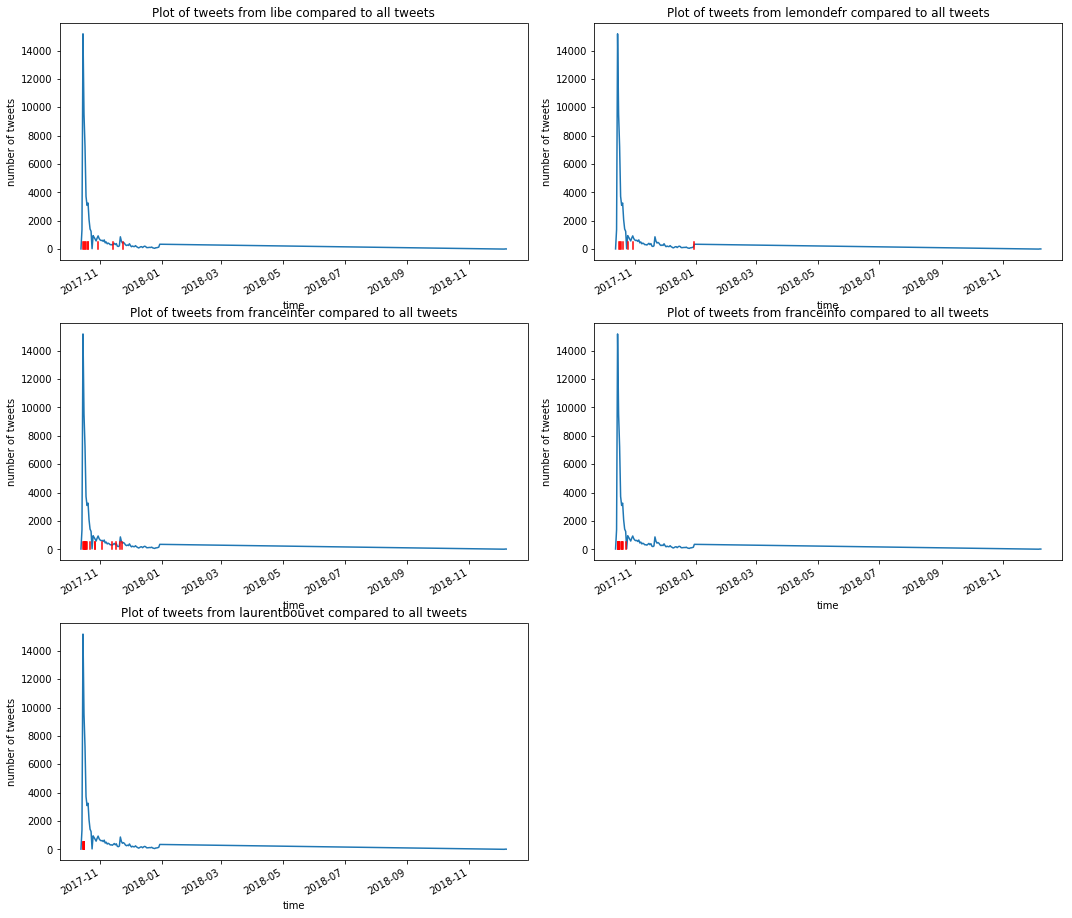

In [18]:
plot_tweets(["libe", "lemondefr", "franceinter", "franceinfo", "laurentbouvet"])

Unsuprisingly, most tweets were made during the first peak. We can notice that one tweet from lemondefr was made before the slight increase on the january 2018, and that a few twets of franceinter matches the second small peak.

### Visualizing pagerank

We know intend to visualize pagerank. For that, we will be using HoloView, a library allowing us to make interactive plot of graphs.

As the graph can be big (more than one thousand nodes), we can't plot it entirely. We need to build a subset of the graph. However, we must be carefull on how to pick our subset. We can't just create the subgraph induced by the one hundred nodes with the highest pagerank rank as the pagerank rank spread some informations along the edges. More concretely, we can have a node a connected to b connected to c, and b with a low pagerank rank, but a and c with a high one.

What we are doing, is instead to pick the ten nodes with the highest pagerank rank and plot a subgraph where these ten nodes are connected together. To ensure this property, we will also take the neightbors of these ten nodes. If the ten nodes are not included in the neighbors, we also pick the neighbors of the neighbors... We repeat the process until the selected nodes includes the ten starting nodes.

In [19]:
toselect = set(indices[:10])

In [20]:
print([graph.vs['name'][i] for i in toselect])

['Le_Figaro', 'franceinfo', 'libe', 'brutofficiel', 'Brevesdepresse', 'leLab_E1', 'le_Parisien', 'lemondefr', 'BFMTV', 'Limportant_fr']


In [21]:
def adjacent_vertices(graph, l):
    """ Get the set of neighbors of nodes in [l]"""
    neighbors = []
    for x in l:
        neighbors += graph.neighbors(x)
    return set(neighbors)

# we start by selecting all the neighbors of toselect
selected = adjacent_vertices(graph, toselect)
# Then, we select the neighbors of the selected nodes 
# until they include our starting nodes
while not (toselect <= selected):
    selected = adjacent_vertices(graph, selected)

Now that we have the node of our subgraph, we can build the subgraph.

In [22]:
graph_plot = graph.subgraph(selected)

We also build a list of the normalized pagerank rank of these nodes.

In [23]:
pagerank_top = [graph_plot.vs['pagerank'][i] for i in graph_plot.vs.indices]
m = max(pagerank_top)
pagerank_top = [p / m for p in pagerank_top]

The next step is to find the position of the nodes in the graph. For that we are using `networkx` and a spring layout.

In [24]:
G = nx.DiGraph()
G.add_nodes_from(graph_plot.vs.indices)
G.add_edges_from(e.tuple for e in graph_plot.es)
pos = nx.spring_layout(G, k=.001)

Then we can build two dataframes: one for the edges, one for the nodes.

In [25]:
edges_pd = pd.DataFrame()
edges_pd['start'] = pd.Series([e.source for e in graph_plot.es])
edges_pd['end'] = pd.Series([e.target for e in graph_plot.es])

In [26]:
nodes_pd = pd.DataFrame()
nodes_pd['x'] = [pos[i][0] for i in graph_plot.vs.indices]
nodes_pd['y'] = [pos[i][1] for i in graph_plot.vs.indices]
nodes_pd['index'] = graph_plot.vs.indices
nodes_pd['name'] = nodes_pd['index'].map(graph_plot.vs['name'].__getitem__)
nodes_pd['size'] = [pagerank_top[i] * 50 for i in graph_plot.vs.indices]

We now use `holoview` to plot the graph. We decided that each node will have a scale propotional to its pagerank rank, as well as a color depending on this rank. Edges are bundled together.

In [27]:
def export_bokeh_tojson(figure, file, plot_name="plot"):
    """ Export a figure to a json representation for bokeh.
    """
    plot = hv.renderer('bokeh').get_plot(figure).state
    f = open(file, 'w')
    f.write(json.dumps(bokeh.embed.json_item(plot, plot_name)))

def export_bokeh_topng(figure, file):
    """ Export a figure to a png
    """
    plot = hv.renderer('bokeh').get_plot(figure).state
    json.dumps(bokeh.io.export_png(plot, filename=file))

In [28]:
%opts Nodes Graph [width=800 height=800 xaxis=None yaxis=None]
%opts Graph (node_size='size' edge_line_width=.25)

graph_vis = hv.Graph((edges_pd, hv.Nodes(nodes_pd)))
graph_vis = bundle_graph(graph_vis)
graph_vis = graph_vis.options(color_index='size', cmap='pastel2')
export_bokeh_topng(graph_vis, "images/btp.png")

![title](images/btp.png)

In [30]:
export_bokeh_tojson(graph_vis, 'pagerank_btp.json')

### Pagerank on #notmypresident

We already illustrated pagerank with the hashtag `balancetonporc`. We have repeated the same analysis on `#notmypresident` below. The main difference is that we computed pagerank on a a 10% sampling of our dump of `#notmypresident`. However, our dump was only made for the month of november 2016, and as we have nearly 500k tweets for this hashtag, the analysis should still be representative.

The results can be found below:

In [13]:
# ranked_users is the top20 users having tweeted #notmypresident ranked by pagerank
ranked_users.head(20)

,name,pagerank
0,realDonaldTrump,0.015478
1,thehill,0.002088
2,CNN,0.001982
3,GeorgeTakei,0.001953
4,PrisonPlanet,0.001906
5,washingtonpost,0.001648
6,nytimes,0.001612
7,KeithOlbermann,0.001377
8,ABC,0.001198
9,JoyAnnReid,0.001167


![title](images/nmp.png)

These results seems a bit absurd at first glance. Why would the most influent user on `#notmypresident` be Trump when this hashtag was used to mock him? In fact, this makes a lot of sense and perfectly shows the weakness of our analysis. As `twint` isn't able to find accurate informations about retweets (and as we didn't managed to find a workaround), we had to approximate retweets. For `#notmypresident` lot of users are retweeting Trump, but only to mock him. As the retweet has the hashtag `#notmypresident`, the way we are building the graph is giving a lot of importance to Trump, which is then reflected by pagerank.

## Time-serie analysis and outliers approximation for balancetonporc

We now study the behavior of the hashtag `#balancetonporc` from the view point of time series. This analysis is not repeated for other hashtags. We compare the behavior of `#balancetonporc` with the behavior of `#moiaussi`.

In [15]:
df = pd.read_json('balancetonporc.json',lines = True)

In [5]:
df.head(5)

,conversation_id,created_at,date,gif_thumb,gif_url,has_parent_tweet,hashtags,id,is_quote_status,is_reply_to,...,retweets_count,tags,time,timezone,tweet,urls,user_id,username,video_thumb,video_url
0,1071507278875033600,2018-12-08 20:50:17,2018-12-08,,,0,[#balancetonporc],1071507278875033600,0,0,...,0,[],21:50:17,CET,Un livreur de pizza qui demande clairement des...,[],777095708692324353,hllelea,,
1,1071495065514721280,2018-12-08 20:01:45,2018-12-08,,,0,[#balancetonporc],1071495065514721280,0,0,...,0,[],21:01:45,CET,J'ai ajouté une vidéo à une playlist @YouTube ...,[http://youtu.be/QYAYnGu_iaw?a],830093777591234560,chouchoue_,,
2,1071483541286993920,2018-12-08 19:15:58,2018-12-08,,,0,[#balancetonporc],1071483541286993920,0,0,...,0,[],20:15:58,CET,#balancetonporc https://www.sudouest.fr/2018/...,[https://www.sudouest.fr/2018/09/05/il-photogr...,882276333291786240,sweetieoparadis,,
3,1071481275528167424,2018-12-08 19:06:57,2018-12-08,,,0,[#balancetonporc],1071481275528167425,0,0,...,0,[],20:06:57,CET,Salut la twitosphère #balancetonporc,[],1042521930849570816,duhippolyte,,
4,1071468524571451392,2018-12-08 18:16:17,2018-12-08,,,0,"[#balancetonporc, #balanceta2000]",1071468524571451392,0,0,...,0,[],19:16:17,CET,Après #balancetonporc il y a #balanceta2000 @L...,[],1065703994,alex____torres_,,


In [3]:
def create_timedate(df):
    
    # merge date and time into a datetime column
    
    df['timedate'] = list(map(lambda el: el[:10]+' ',list(map(str,df.loc[:,'date'])))) + df.loc[:,'time']
    
    df['timedate'] = df['timedate'].apply(lambda t: dateutil.parser.parse(t))
    
    # Sets index of dataframe to datetime in order to perform time series analysis

    df = df.set_index('timedate') 
    return df

In [2]:
def countby_upto(t,df):
    
    '''
    Input:
        t - a number from 0 t0 5, where 0 indicates that we should consider timedate up to its seconds unit
        df - dataframe
    Output:
        dataframe with a datetime index in order to perform our time series analysis
        
    '''
    
    df1 = df.copy()
    df1['timedate'] = list(map(lambda el: el[:-3 * time_to_num[t]],list(map(str,df1.index))))
    return df1.groupby(df1['timedate']).size().reset_index().rename(columns = {0:'count'}).set_index('timedate')

In [1]:
tmp = [('second',0),('minute',1),('hour',2),('day',3),('month',4),('year',5)]
time_to_num = dict(tmp)

In [16]:
df = create_timedate(df)

# We will analyze tweets on an hourly basis
df1 = countby_upto('hour',df)

We use pandas implementation DataFrame.rolling(window).mean() to smooth the original timeseries in order to identify trends. The wider the window, the smoother the trend. In the case of very noisy data, this procedure can help detect common patterns.

In [6]:
data = pd.read_json('./data/moiaussi.json',lines = True)

In [7]:
data = create_timedate(data)
data1 = countby_upto('hour',data)

In [12]:
print('The hashtag #balancetonparc was first tweeted at {0}'.format(min(df.index)))
print('The hashtag #balancetonparc was last tweeted at {0}'.format(max(df.index)))
print('The hashtag #moiaussi was first tweeted at {0}'.format(min(data.index)))
print('The hashtag #moiaussi was last tweeted at {0}'.format(max(data.index)))

The hashtag #balancetonparc was first tweeted at 2017-10-13 14:06:32
The hashtag #balancetonparc was last tweeted at 2018-12-08 21:50:17
The hashtag #moiaussi was first tweeted at 2009-07-02 12:05:36
The hashtag #moiaussi was last tweeted at 2018-12-16 01:26:24


We can see that some of the extracted tweets for the #moiaussi hashtag date back to 2009, and we assume that these data 
are not of interest for us, because we are interested in extracting the tweets with the #moiaussi hashtag that are related to the metoo movement, and hence to balancetonporc. However, we noticed that many of the tweets that contain the #moiaussi hashtag also contain the metoo hashtag, so we thought we could extract the data of interest by filtering tweets that contain both hashtags.

In [8]:
tmp = data[data['hashtags'].apply(lambda el: '#moiaussi' in el and '#metoo' in el)]

In [14]:
len(tmp) - len(tmp[tmp.index >= dateutil.parser.parse('2017-10-13 14:06:32')])

44

We still observe a big difference in starting date for both hashtags (about 6 years). In order to further filter the necessary data and avoid analyzing the differences resulting from such difference, we only consider the tweets from the #moiaussi hashtag that have a starting time of at least equal to the balancetonporc hashtag.

In [15]:
max_tweet1 = df[str(np.argmax((df.loc[:,'retweets_count'])))]
max_tweet2 = data[str(np.argmax((data.loc[:,'retweets_count'])))]

In [16]:
max_tweet1['retweets_count']

timedate
2017-10-31 12:10:14    20351
Name: retweets_count, dtype: int64

In [17]:
max_tweet2['retweets_count']

timedate
2017-10-19 22:48:25    511
2017-10-19 22:48:25    511
Name: retweets_count, dtype: int64

We obtained two rows for the 2nd hashtag, but we notice that it is just the same data duplicated. After analyzing the most retweeted tweets for the two hashtags, we also noticed that they are very close to one another in the timeline, which also corresponds to the date when the metoo movement gained traction. Also, as confirmed by our graphs,the number of retweets for the first hashtag is almost twice the number of retweets for the 2nd hashtag. This data is also supported by a larger number of sexual harrasment cases in France compared to Canada. The higher number of retweets of the tweets with the given hashtag is also supported by an average of around 4 retweets per user for the #balancetonporc case compared to a mean of 1 retweet per user for the #moiAussi hashtag.

In [18]:
retweet_mean1 = (df['retweets_count'].sum())/len(df)
retweet_mean2 = (data['retweets_count'].sum())/len(data)

In [19]:
print('mean retweet count for #balancetonporc is {0} and for #moiAussi is {1}'.format(retweet_mean1,retweet_mean2))

mean retweet count for #balancetonporc is 4.715217056757929 and for #moiAussi is 1.101981234647445


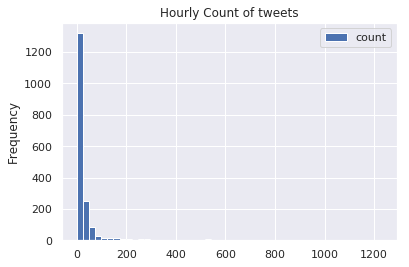

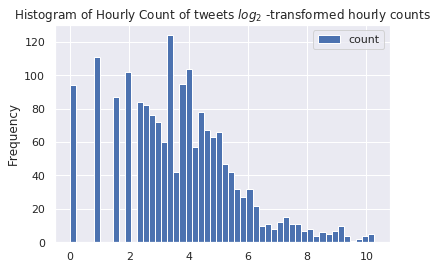

In [ ]:
df1.plot.hist(bins=50, title="Hourly Count of tweets");
np.log2(df1).plot.hist(bins=50,
                      title="Histogram of Hourly Count of tweets $log_2$ -transformed hourly counts");

In [11]:
def plotMovingAverage(series, window,scale=1.96,anomalies = False):

    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    mae = mean_absolute_error(series[window:], rolling_mean[window:])
    deviation = np.std(series[window:] - rolling_mean[window:])
    lower_bond = rolling_mean - (mae + scale * deviation)
    upper_bond = rolling_mean + (mae + scale * deviation)
    plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
    plt.plot(lower_bond, "r--")

    if anomalies == True:
        anomalies = pd.DataFrame(index=series.index, columns=series.columns)
        anomalies[series<lower_bond] = series[series<lower_bond]
        anomalies[series>upper_bond] = series[series>upper_bond]
        plt.plot(anomalies, "ro", markersize=10)

    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)
    

In [36]:
def get_anomalies(series, window,scale=1.96):
    
    rolling_mean = series.rolling(window=window).mean()
    
    mae = mean_absolute_error(series[window:], rolling_mean[window:])
    deviation = np.std(series[window:] - rolling_mean[window:])
    lower_bond = rolling_mean - (mae + scale * deviation)
    upper_bond = rolling_mean + (mae + scale * deviation)
    
    anomalies = pd.DataFrame(index=series.index, columns=series.columns)
    anomalies[series<lower_bond] = series[series<lower_bond]
    anomalies[series>upper_bond] = series[series>upper_bond]
    anomalies = pd.DataFrame(index=series.index, columns=series.columns)
    anomalies[series<lower_bond] = series[series<lower_bond]
    anomalies[series>upper_bond] = series[series>upper_bond]
    
    # drop the values outside the window size
    return anomalies.dropna()

A low smoothing factor means that our smoothed (detrended) data will have a high variance, while a high smoothing factor will result in a low variance, high bias, but it will enable us to better analyze a spike. A smoothing factor of 1 will result in the graph itself.

In [13]:
def standardize(df): 
    return (df - df.mean()) / df.std()

From the plot of standardized twitter counts, we can clearly observe that there is a spike in the beginning, because of the attention that this movement (metoo) attracted at the time, and with time, the number of tweets falls drastically and doesn't change by a large margin in an hourly basis

Lots of regular oscillations can be saw below. In fact, we can explain why they are present. The hashtag `#balancetonporc` is a francophone hashtag: most of the users who tweeted about it are physically located in the same country and on the same timezone. In other word, they are sleeping at the same time. As the number of tweets someone can post logically go down when this person sleep, these oscillations are normal.

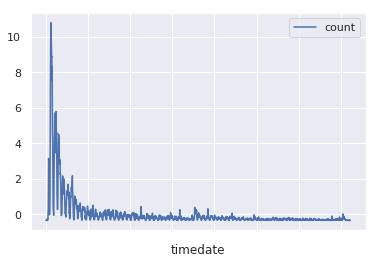

In [ ]:
standardize(df1).plot()

The method below is used to plot some normal data with standard deviation = 1 and mean = 0 and compare it with our data
in order to check whether our data is normalized or not

In [ ]:
def gen_normal_plot(df):
    
    plt.plot(df.index.values,
             np.random.normal(size=df.shape[0]),
             lw=0.8,
             alpha=0.75)
    
    plt.ylim((-5, 5))
    plt.title("Generated normal time series with $\sigma$ bands")

    plt.axhline(y=1, color="red")
    plt.axhline(y=-1, color="red")

    arrowprops = dict(arrowstyle="-",
                      color="black",
                      lw=2)

    plt.annotate("$\sigma$",
                 xy=(df.index.values[1000], 1),
                 xytext=(df.index.values[1000], -1.5),
                 arrowprops=arrowprops)

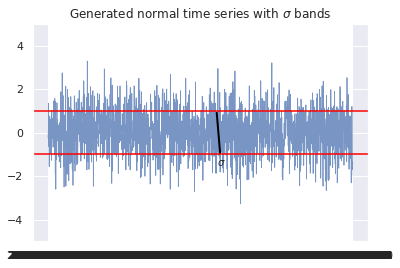

In [ ]:
gen_normal_plot(df1)

As we can see, the distribution of the hourly count of tweets falls outside the $[-\sigma,\sigma]$ range, 
where $\sigma$ denotes the standard deviation, supporting our previous observation that the data is skewed, which
is not anomaly in this case, because clearly the number of tweets with a given hashtag will be very high when a hashtag
initially emerges, but as this popularity is ephemeral, the number of tweets will soon approach 0.

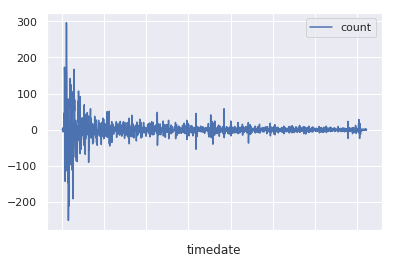

In [ ]:
df1.diff().plot()

The above graph clearly demonstrates the huge difference in counts when the twitter first gains traction, and then when
it dissapears into obscurity.

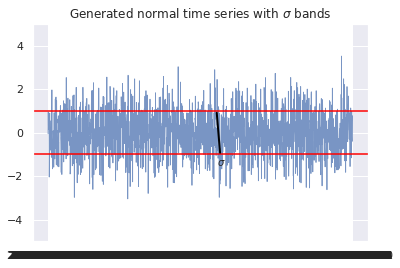

In [ ]:
gen_normal_plot(standardize(np.log2(df1)))

Log transformation before standardization helps give more reasonable standardized values, even if the log-transform isn't quite enough to make this data normal

We will now use the plotMovingAverage function to plot the daily trends in tweets, and see how the actual trend in a tweet compares with the normal one. In order to get the daily trend, we set the moving window to 24h. This parameter
can be changed to any number, but it will afect the smoothed graph. A small number will produce a graph with a low bias,
while a large number, will produce a graph with high variance.

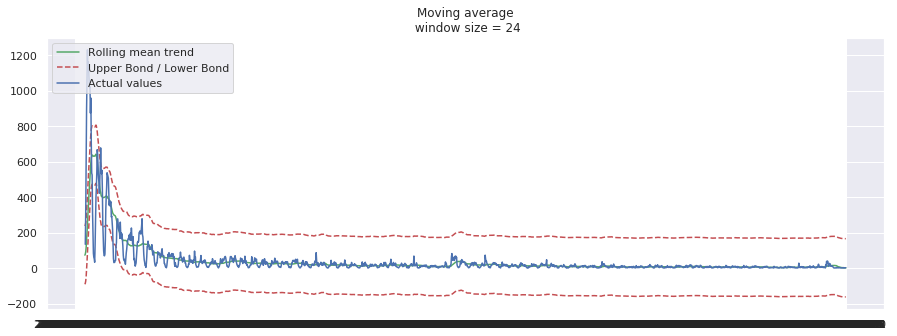

In [ ]:
# Get the daily trend
plotMovingAverage(df1,24)

From the above graph, we can observe that the data follows the expected daily trend, i.e., the smoothed data almost perfectly fits our normal data. We can also plot the confidence interval, to see how confident we should be in the correctness of our smoothed data.

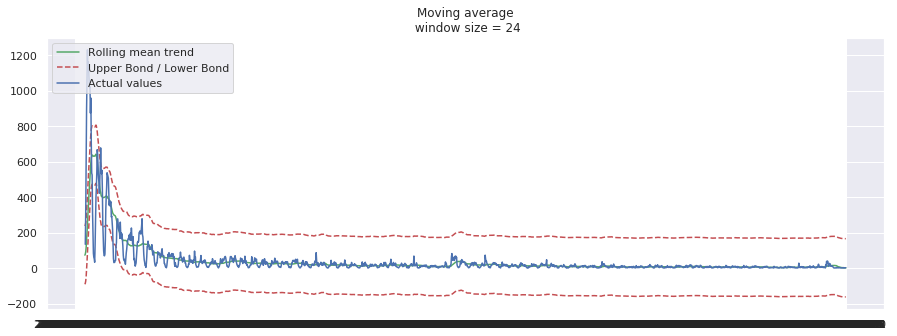

In [ ]:
plotMovingAverage(df1,24)

In order to detect deviations from the expected trend, we set plot_anomalies to true 

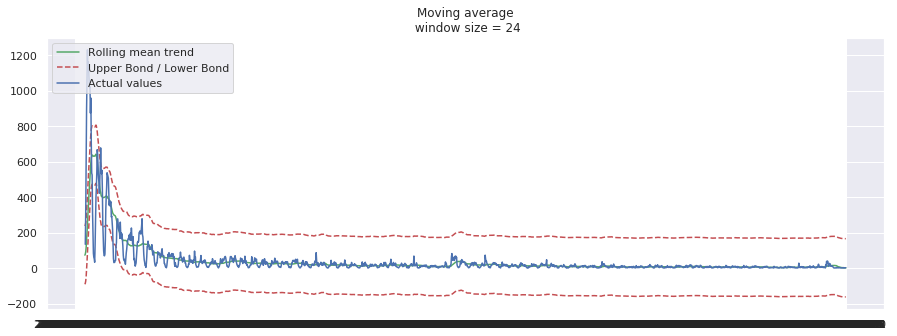

In [40]:
plotMovingAverage(data1,24,anomalies = True)

The above model of rolling window is way too simplistic and it doesn't account for trends and seasons in our data, although it can be used as a baseline. A more complex model is needed to account for seasons and trends in our data, and we found Holt-Winters to be one such model.

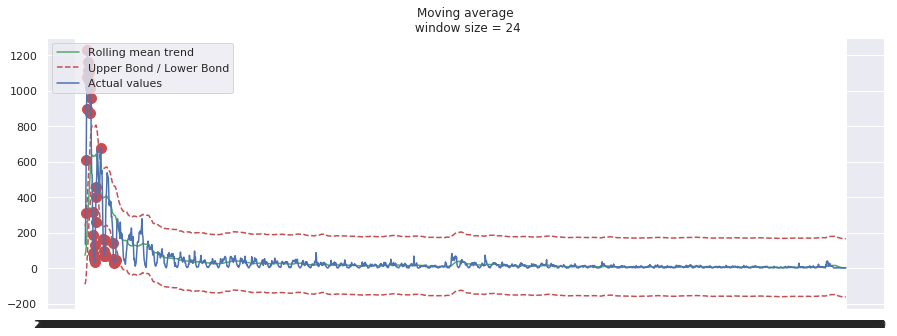

In [ ]:
plotMovingAverage(df1,24,anomalies = True)

In [ ]:
plotMovingAverage(data1,24,anomalies = True)

The plots obtained from the rolling window method seem to reject our hypothesis that the two hashtags follow a similar pattern of time spread on an hourly basis. In order to further investigate the reasons for such difference we first try to look at the timeline for both the hashtags.

In [9]:
tmp = tmp[tmp.index >= dateutil.parser.parse('2017-10-13 14:06:32')]

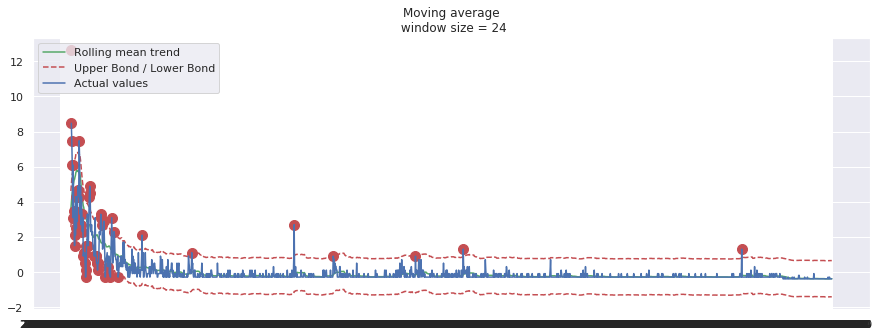

In [14]:
plotMovingAverage(standardize(countby_upto('hour',tmp)),24,anomalies = True)

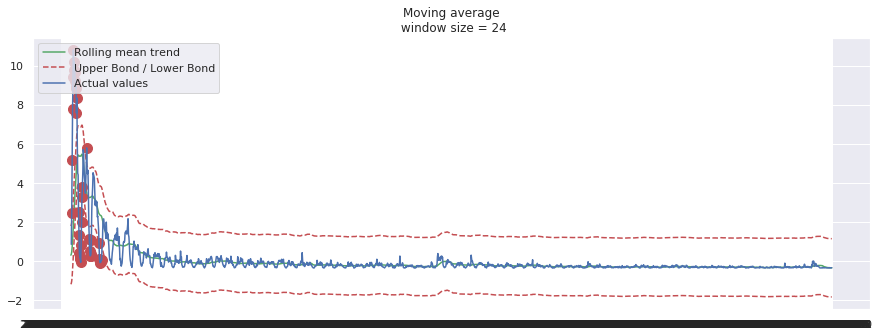

In [18]:
plotMovingAverage(standardize(df1),24,anomalies = True)

We can now clearly see that both time series follow a very similar pattern, with very similar "anomalies" and spikes, although the amplitude of the spikes is different, which is expected given their popularity in different geographical areas. The notion of difference in time series is formalized by applying the dynamic time warping algorithm.

In [77]:
# A list of tuple of (hour, number of occurrences of tweets) for anomalies

dist1= list(zip(list(map(int,anomalies1.values)),list(map(lambda el:el.hour,list(map(dateutil.parser.parse,anomalies1.index))))))

dist2= list(zip(list(map(int,anomalies2.values)),list(map(lambda el:el.hour,list(map(dateutil.parser.parse,anomalies2.index))))))

In [71]:
anomalies1 = get_anomalies(df1,24)
anomalies2 = get_anomalies(data1,24)

In [78]:
x = np.array(dist1)
y = np.array(dist2)
distance, path = fastdtw(x, y, dist=euclidean)
print(distance)

55152.38366431613


The reason that we only use anomalies to compute dtw in this case is because the progression of anomalies best captures the distance between two time series. For example, suppose we have three time series t1, t2 and t3 such that t2 and t3 are related, t1 and t2 are related, but t1 and t3 are not. Hence, t2 may have some anomalies that are related to the events modeled by t3, which will be missing in t1. Hence, if we consider every point, it is likey that we'll conclude that t1 and t2 are not related. However, by only measuring the distance between anomalies, we can capture the relation between t1 and t2 by ignoring certain events which are modeled by t2 and are related to t3. 